In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation

from matplotlib import rcParams
# font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# 10.1 ODE solvers 2 <a class="tocSkip">
    
Lecture 10.1  
Matt Piggott

## Table of Contents
```{contents}
```

## Learning objectives:  <a class="tocSkip">


* To extend the simple time-stepping schemes seen previously to families of far more sophisticated and powerful methods, including more on RK methods briefly introduced in Comp Math.


* To introduce linear multistep methods as a second family/class of methods.


* To provide more detail on stability, errors, and time step selection.


* As well as solving ODEs as they are interesting in their own right, in later lectures we will be considering PDEs, and all of the ideas and methods introduced here are important for dealing with *time-dependent* PDEs.


<br>

<br>

**Note that there are many optional and advanced sections indicated in these notes - as always you can safely ignore all of these.**


## Review

## Problem definition

Recall that the numerical solution of ODEs involves solving approximating the solution to problems such as

$$\text{find} \;\;\;\; \boldsymbol{y}\equiv\boldsymbol{y}\,(t) \;\;\;\;\;\; \text{such that} \;\;\;\;\;\; 
\frac{d{\boldsymbol{y}}}{dt} = \boldsymbol{f}\,(t,\boldsymbol{y}\,(t)),\;\;\;\;\;\; \boldsymbol{y}(0)=\boldsymbol{y}_0,$$

where $\boldsymbol{f}\,$ is a given function of time as well as the unknown variable $\boldsymbol{y}\,$, which is itself a function of $t$ (we won't always bother explicitly writing this dependence). 

$\boldsymbol{y}_0$ is a prescribed *initial condition*.


<br>

<br>

We can think of $\boldsymbol{y}\equiv\boldsymbol{y}(t)$ as mapping out a trajectory in a [*phase space*](https://en.wikipedia.org/wiki/Phase_space) which is the same dimension as our ODE system 

For example, in 1D

<br>

```{figure} Figures/FE-one-step.png
:width: 75%
```

in 2D

```{figure} Figures/circular_orbits_trajectories.png
:width: 75%
```

and in 3D

```{figure} Figures/lorenz_attractor.png
:width: 75%
```

<br>
<br>

At any point in time the first-order ODE above is telling us the local direction of the trajectory and our job is to move forward in time, mapping out this trajectory. 

We generally assume that the RHS function  $\,\boldsymbol{f}\,$ is "*nice*", in that the derivatives of $\,\boldsymbol{f}\,$ and smooth and we can make use of [Taylor series](https://en.wikipedia.org/wiki/Taylor_series) based analysis to both derive and analyse the expected behaviour of different ODE solvers.

<br>

Recall also that the RHS function may be a function of the independent variable (here $t$), the dependent variable(s) (here $\boldsymbol{y}$) or both.


## Notation

To form a discrete version of our problem, i.e. one that is solvable on a finite computer, we approximate the problem/solution at a series of time levels

$$t_0<t_1<t_2<\cdots$$

where $\,t_0\,$ is our initial time, i.e. we will generally assume for simplicity that $\;t_0 = 0$. 

We will use the notation $T$ if there is an upper limit on how far we will integrate in time - but note that this might be unbounded ($t \in [0,T]$ or $t \in [0,\infty)$).

It will often (but not always) be the case that our time step size is constant, i.e. $\;\;t_{n+1} - t_{n} = \Delta t$, $\;\;\forall\, n=1,2,\ldots$.

Otherwise we can specify a local time step size as $\;\;t_{n+1} - t_{n} = \Delta t_{n}$.

Our discrete numerical solution (approximation) at each of these time levels will be denoted by

$$\boldsymbol{y}_n \approx \boldsymbol{y}\,(t_{n}).$$

Note that we will use the notation $n$ to indicate a time level. 

<br><br>

In later lectures where we are solving PDEs in time and space we will use *sub*scripts $i$, $j$ and $k$ (with the number of indices needed depending on the number of spatial dimensions) to represent spatial points, and will still use $n$ to indicate time level but will use a superscript following standard convention (i.e. $u_{ij}^n \approx u(x_i,y_j,t_{n})$). Here, as we have no spatial indices to worry about and get in the way, the norm is generally for $n$ to be written as a subscript.


## Convergence

We will generally require that our numerical solution satisfies two properties:


1. **Convergence** - this can be defined formally as 

$$\max_{0\,\le \,t_n\, \le\, T}\| \boldsymbol{y}_n - \boldsymbol{y}\,(t_{n})\| \longrightarrow 0 \;\;\;\; \text{as} \;\;\;\; \Delta t \longrightarrow 0. $$




2. **Correct qualitative behaviour** - even for finite (non infinitesimally small) $\Delta t$ we ideally would like numerical methods which yield approximations having the same qualitative behaviour as the exact solution. For example, they respect properties such as *conservation laws*, converge to a certain value or periodic orbit, or are bounded, e.g. they do not go negative when we know the quantity being integrated cannot physically be negative, such as would be the case for a concentration.

## Model Problem: exponential decay

Recall our model problem

$$\frac{dy}{dt} = K(y_r - y),$$

where $K$ is a coefficient that dictates how quickly the relaxation occurs, and $y_r$ is the value which we are relaxing to (can you see what the units of $K$ must be?).


This linear IVP has the exact (analytic) solution

$$ y(t) = y_r + (y(0) - y_r)\exp(-Kt).$$


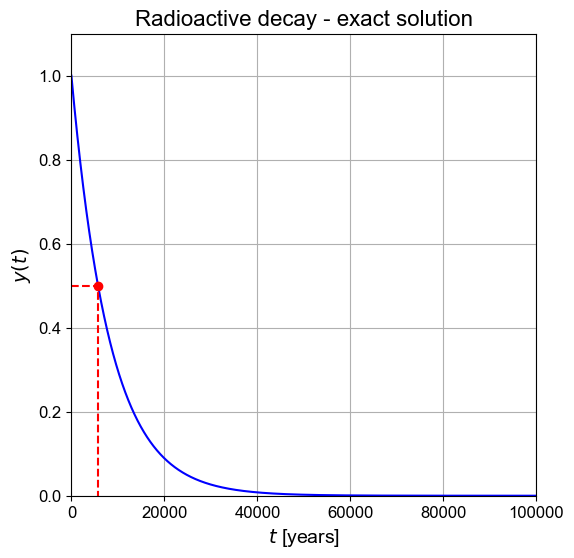

In [2]:
yr = 0.0
y0 = 1.0
C_14_half_life = 5730. #  our temporal units here are assumed to be years
# and the following is how you turn a "half life value" into a "decay constant"
K = np.log(2.)/C_14_half_life 

# let's plot things over 100,000 years
t = np.arange(0., 100000., 1.)

def y_ex(t):
    """ Function to evaluate the exact solution to the exponential decay problem.
    """ 
    return (yr + (y0-yr)*np.exp(-K*t))

fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)
ax1.plot(t, y_ex(t), 'b')

# red dashed lines and dot emphasise the meaning of "half life"
ax1.plot([5730], [0.5], 'ro')
ax1.plot([0, 5730, 5730], [0.5, 0.5, 0], 'r--')

ax1.set_xlabel(r'$t$ [years]', fontsize = 14)
ax1.set_ylabel(r'$y(t)$', fontsize = 14)
ax1.set_title('Radioactive decay - exact solution', fontsize = 16)
ax1.grid(True)
ax1.set_xlim(0,100000)
ax1.set_ylim(0,1.1);

## Simple numerical approximations

Recall that there are several approaches for us to formulate a numerical approximation to this problem.


## Forward Euler

The first is to note that this ODE provides information about the local gradient of the solution.

If we decide to use information about the current time $t_{n}$ and state $y_{n} \approx y(t_{n})$ only, then the simplest possible discretisation of our ODE $\,(\dot{y}=f(y))\,$  is to use a so-called *forward difference* to approximate the gradient:

$$\frac{y_{n+1}-y_{n}}{\Delta t} = f(y_n),$$

where for our model problem, $\;\;f(y) := K(y_r - y)$.

This corresponds to linear extrapolation and the scheme is usually referred to as a **forward Euler**, or **explicit Euler**, discretisation. The terms forward or explicit are appropriate descriptions as we are using on the RHS information we already know (what would a straightforward alternative be?)

Rearranging (e.g. for implementation in code as we will see below) we have the update formula:

$$y_{n+1} = y_{n} + \Delta t K(y_r - y_n).$$

Next we plot a schematic to see what the scheme is doing over one time step, 

then we will implement the scheme in full and compare to our exact solution.

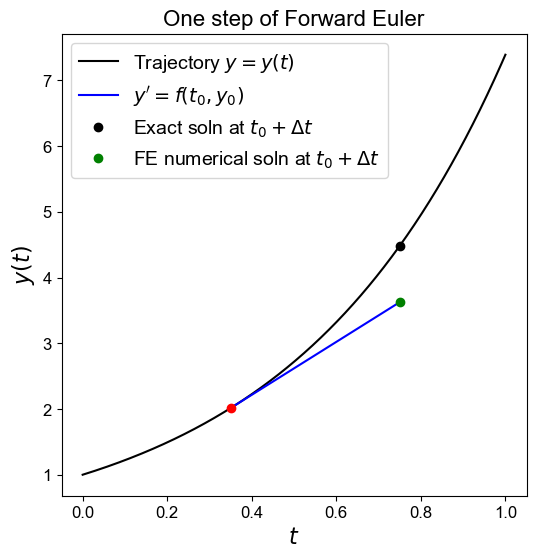

In [3]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(111)
ax1.set_title('One step of Forward Euler', fontsize=16)
ax1.set_xlabel('$t$', fontsize=16)
ax1.set_ylabel('$y(t)$', fontsize=16)

t = np.linspace(0, 1, 1000)

# an example solution trajectory (or solution to ODE $\dot{y}=f(y)$)
def y(t):
    return np.exp(2.*t)

# and this is the derivative of that y which has to equal the RHS of the ODE
def dy(t):
    return 2.*np.exp(2.*t)

ax1.plot(t, y(t), 'k', label='Trajectory $y=y(t)$')

# this is just some location in time
t0 = 0.35
# and an example of a time step size large enough we can see what the method is doing
dt = 0.4

ax1.plot([t0, t0 + dt], [y(t0), y(t0) + dt * dy(t0)], 'b', label = r"$y'=f(t_0,y_0)$")
ax1.plot([t0], [y(t0)], 'ro')

ax1.plot([t0 + dt], [y(t0 + dt)], 'ko', label='Exact soln at $t_0 + \Delta t$')
ax1.plot([t0 + dt], [y(t0) + dt * dy(t0)], 'go', label='FE numerical soln at $t_0 + \Delta t$')
ax1.legend(loc='best', fontsize=14);

#### Comments


- In the above image we assume we know the exact solution, i.e. we start from the red dot that lies on the exact solution (i.e. the curve the solution makes in $(t, y(t))$ space).


- At a later time the black dot shows where we should be; the green dot shows where the numerical method takes us; the difference is the error.


- Since we assumed we started at the exact solution, this error is called the *local* or the *one-step error*. Note that for every subsequent time step where we cannot assume we start from a point on the exact solution trajectory there is potential (indeed a likelihood) for these *local errors to accumulate and grow* We will define these terms below, but perhaps unsurprisingly this is termed the *global error*.


- It should hopefully also be clear that the error in the image above can get worse in one of two ways: (1) it will be larger if we take a larger sized step; (2) it will also be larger if the black line diverges from the blue line more rapidly - in this case of the forward Euler method this rate of divergence depends on the second derivative of $y(t)$, or equivalently the first derivative of $f$ w.r.t. $t$.

## Taylor series approximation

Recall that Taylor series in one dimension tells us that we can approximate the value of the function at a location in terms of its value, and value of its derivative, at a nearby point:

$$ y(t+\Delta t) = y(t) + \Delta t \, y'(t) + \frac{\Delta t^2}{2!}y''(t) + \frac{\Delta t^3}{3!}y'''(t) + \mathcal{O}(\Delta t^4),$$
 
where $\mathcal{O}(\Delta t^4)$ represents the collection of terms that are fourth-order in $\Delta t$ and higher.

Using the notation $y_n=y(t_n)$, and assuming a uniform time step, this is equivalent to 

$$ y_{n+1} = y_n + \Delta t\, y'_n + \frac{\Delta t^2}{2!}y''_n + \frac{\Delta t^3}{3!}y'''_n + \mathcal{O}(\Delta t^4).$$

Dropping second-order and higher terms, or *truncating* the expansion, (which we can justify if $y$ is "smooth", which means that $y''$ is "well-behaved", and $\Delta t$ being sufficiently small), and noting that $y'_n = f(t_n,y_n)$ we are left with

$$y_{n+1} = y_n + \Delta t \, f(t_n,y_n),$$

i.e. our forward Euler method from just above.

## Using numerical differentiation

Another approach is to consider the ODE at a single point in time (assuming for simplicity we have a scalar system so drop the bold vector notation):

$$\left.\frac{d{y}}{dt}\right|_{t=t_{n}} =\; {f}(t_{n},{y}(t_{n})).$$

[The vertical bar with $t=\ldots$ at the bottom just means "evaluated at" that $t$ value.]

<br>

Then we can use a *finite difference* formula to approximate the LHS, and substitute the numerical solution at level $n$ $(y_{n}\approx y(t_{n}))$ into the RHS (i.e. 
${f}(t_{n},{y}(t_{n}))\approx {f}(t_{n},{y}_{n})$).

[We will explain ***finite difference formulae*** properly next lecture, but in the meantime just note that we can approximate a derivative in the following ways:

$$
\begin{align*}
\left.\frac{d{y}}{dt}\right|_{t=t_{n}} & = \lim_{h\rightarrow 0} \frac{y(t_n+h)-y(t_n)}{h} \\[5pt]
& \approx \frac{y(t_n+\Delta t)-y(t_n)}{\Delta t} = \frac{y(t_{n+1})-y(t_n)}{\Delta t} 
 \approx  \frac{y_{n+1}-y_n}{\Delta t} 
\\[10pt]
\text{or} \;\;\; & \approx \frac{y(t_n)-y(t_n-\Delta t)}{\Delta t} = \frac{y(t_n)-y(t_{n-1})}{\Delta t}  \approx \frac{y_n-y_{n-1}}{\Delta t} \\[10pt]
\text{or} \;\;\; & \approx \frac{y(t_n+\Delta t)-y(t_n-\Delta t)}{2\Delta t} = \frac{y(t_{n+1})-y(t_{n-1})}{2\Delta t} \approx \frac{y_{n+1}-y_{n-1}}{2\Delta t},
\end{align*}
$$

with the three approximate expressions all being valid
discretisations of the derivative; with all of them being increasingly accurate for smaller choices of $\Delta t$.]

### Four simple schemes

With this approach we can immediately write down forward Euler as well as three new equally valid schemes:

- a *forward difference* leads to 

$$\frac{y_{n+1} - y_{n}}{\Delta t} = {f}(t_{n},{y}_{n}) \;\;\; \iff \;\;\; y_{n+1} = y_{n} + {\Delta t}\,{f}(t_{n},{y}_{n})$$

which we recognise as the **forward Euler** or **explicit Euler** method from the previous lectue.

- a *backward difference* leads to [this comes from the second approximate derivative above, but where we have updated the notation $n\rightarrow n+1$ to follow normal notation convention]

$$\frac{y_{n+1} - y_{n}}{\Delta t} = {f}(t_{n+1},{y}_{n+1}) \;\;\; \iff \;\;\; y_{n+1} - {\Delta t}\,{f}(t_{n+1},{y}_{n+1}) = y_{n}$$

which is called the **backward Euler** or **implicit Euler** method. Note that this results in an *implicit* equation for $y_{n+1}$, and 

- a *central difference* leads to [this is the third approximate derivative above]

$$\frac{y_{n+1} - y_{n-1}}{2\Delta t} = {f}(t_{n},{y}_{n}) \;\;\; \iff \;\;\;  y_{n+1} = y_{n-1} + 2\,{\Delta t}\,{f}(t_{n},{y}_{n})  $$

which is called the **leapfrog** method.

#### Comments


- One observation here is that forward Euler and leapfrog are what are termed *explicit* schemes in that $y_{n+1}$ can be computed explicitly using information already available (e.g. from previous time levels), this leads to simple time stepping loops (and implementations in code). 


- Backward Euler on the other hand is what is termed an *implicit* scheme in that it leads to an equation for $y_{n+1}$ which can not be written in the form of $y_{n+1}=$ *some combination of known values*, as $y_{n+1}$ appears on both sides of the equation.


- For implicit relations, the approach needed to solve the problem depends on whether we are dealing with a scalar or vector system, and whether $f$ is linear or nonlinear in $y$. 


- A further observation is that for leapfrog we have a problem at the start where we only know $y_0$, but we need $y_1$ to use the formula to compute $y_2$ in the first leapfrog step.  This problem is described by the phrase that the scheme is ***not self-starting***. To address this we need to use a self-starting scheme to compute enough values from $y_0$ to get the non-self-starting method going. We could just use a simpler methods such as forward or backward Euler, and if concerned that the simplicity may introduce unacceptable errors, we could solve over the initial period with a smaller time step. We could also use an explicit scheme with the correct order of accuracy (we will see an example of this in the homework). In the example below we will just use an initial forward Euler step to estimate $y_1$.

A further obvious scheme (which can be obtained by adding together forward and backward Euler schemes, and hence cancelling some of their errors (cf. the lecture on quadrature where we combined estimated from two rules to obtain a third more accurate estimate) as we shall see below) is

$$
\begin{align*}
\frac{y_{n+1} - y_{n}}{\Delta t} & = \frac{1}{2}\left({f}(t_{n},{y}_{n}) + {f}(t_{n+1},{y}_{n+1})\right) \\[5pt] 
\iff \;\;\;  
 y_{n+1} - \frac{\Delta t}{2}{f}(t_{n+1},{y}_{n+1}) & =  y_{n} + \frac{\Delta t}{2}{f}(t_{n},{y}_{n}),
 \end{align*}
$$

which is called the **trapezoidal** scheme. 

Note that as the function $f$ evaluated at our newest time level appears in this relation, this scheme is also implicit.

## An example application

Let's now write some code to see how these four simple methods perform for our exponential decay model problem (where for simplicity we set the value we relax to, $y_r$, to zero). 

Note that in the case of a ***scalar linear*** problem, as is the current case we're considering, it's easy for us to deal with the issue of implicit schemes simply by rearranging our time-stepping update formula.

Note that this won't be the case for vector and/or nonlinear systems as we shall see later, and thus more work is required in these cases.

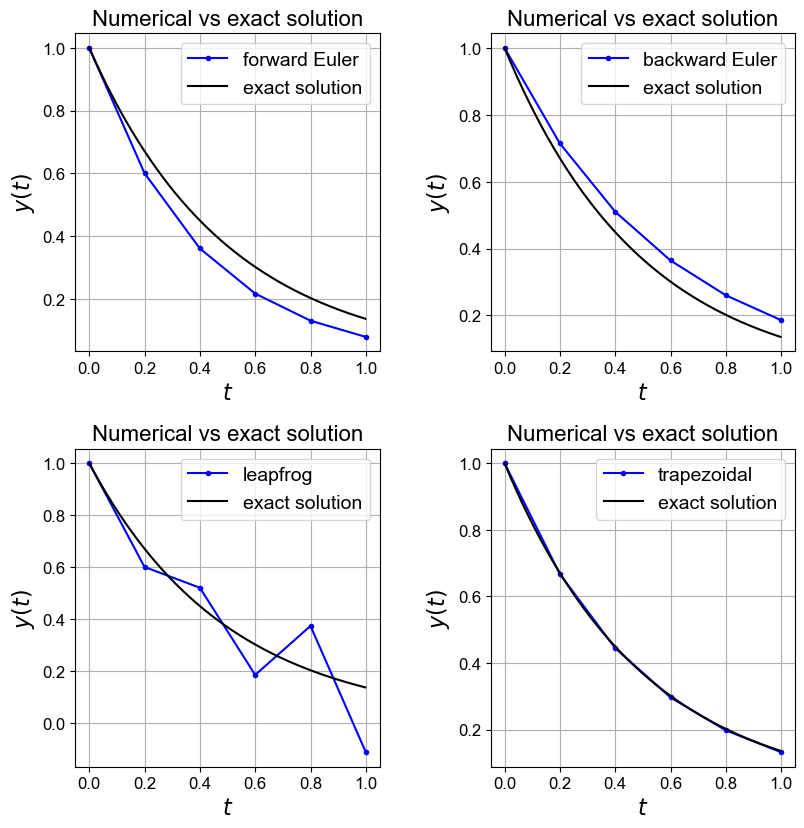

In [4]:
# define physical parameter
K = 2
# initial condition
y0 = 1
# and some numerical parameters
dt = 0.2
tend = 1.0

def f(t, y):
    return -K*y

def y_ex(t):
    """ Function to evaluate the exact solution to the exponential decay problem with y_r=0
    """ 
    return y0*np.exp(-K*t)

# let's use a finer resolution to plot the exact solution 
# to give a smooth curve in our plot
tfine = np.arange(0, tend, dt/100)

# set up figure with 4 subplots to plot our 4 methods
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=4)

# our time levels for the numerical solution
N_dt = int(round(tend/dt))
t = dt * np.linspace(0, N_dt, N_dt + 1)
# an alterntive would be two use
# t = np.arange(0, tend, dt)
# but round-off means that can miss the tend value
# alternatively we could use something like
# t = np.arange(0, tend+1.e-10, dt)
# but the 1.e-10 increment needs to be relative

# a time loop to implement forward Euler
y = np.empty(len(t))
y[0] = y0
for (n, t_n) in enumerate(t[:-1]):
    # note for this example this is the same as y[n]*(1-dt*K)
    y[n+1] = y[n] + dt * f(t_n, y[n])

axs[0].plot(t, y, 'b.-', label='forward Euler')
axs[0].plot(tfine, y_ex(tfine), 'k', label='exact solution')
axs[0].set_xlabel('$t$', fontsize=16)
axs[0].set_ylabel('$y(t)$', fontsize=16)
axs[0].set_title('Numerical vs exact solution', fontsize=16)
axs[0].grid(True)
axs[0].legend(loc='best', fontsize=14)

# backward Euler
y = np.empty(len(t))
y[0] = y0
for n in range(0, len(t) - 1):
    # note that for this simple problem we can rearrange the 
    # implicit expression and hence do not need to use the 
    # f function - if we did we would need to use an 
    # implicit equation solver such as was introduced in L4
    y[n+1] = y[n]/(1 + dt*K)

axs[1].plot(t, y, 'b.-', label='backward Euler')
axs[1].plot(tfine, y_ex(tfine), 'k', label='exact solution')
axs[1].set_xlabel('$t$', fontsize=16)
axs[1].set_ylabel('$y(t)$', fontsize=16)
axs[1].set_title('Numerical vs exact solution', fontsize=16)
axs[1].grid(True)
axs[1].legend(loc='best', fontsize=14)

# leapfrog
y = np.empty(len(t))
y[0] = y0
y[1] = y[0] + dt*f(t[0], y[0]) # leapfrog not self-starting so do a FE step here
for n in range(1, len(t) - 1):
    # as a two step scheme this uses the solution at level n as well as n-1
    y[n+1] = y[n-1] + 2.0 * dt * f(t_n, y[n])

axs[2].plot(t, y, 'b.-', label='leapfrog')
axs[2].plot(tfine, y_ex(tfine), 'k', label='exact solution')
axs[2].set_xlabel('$t$', fontsize=16)
axs[2].set_ylabel('$y(t)$', fontsize=16)
axs[2].set_title('Numerical vs exact solution', fontsize=16)
axs[2].grid(True)
axs[2].legend(loc='best', fontsize=14)

# trapezoidal
y = np.empty(len(t))
y[0] = y0
for n in range(0, len(t) - 1):
    # as for BE rearrange the implicit relation to obtain an update formula
    y[n+1] = y[n] * (1.0 - K*dt/2.0) / (1.0 + K*dt/2.0)

axs[3].plot(t, y, 'b.-', label='trapezoidal')
axs[3].plot(tfine, y_ex(tfine), 'k', label='exact solution')
axs[3].set_xlabel('$t$', fontsize=16)
axs[3].set_ylabel('$y(t)$', fontsize=16)
axs[3].set_title('Numerical vs exact solution', fontsize=16)
axs[3].grid(True)
axs[3].legend(loc='best', fontsize=14);

#### Comments 

- Note that in the implementations above we stored the solution at all time levels - this is because this is cheap for us to do here, and we want the option of plotting the whole solution trajectory. In general, and for larger problems, this won't be feasible. In which case we might just return the final solution, or the solution at specified times (as the SciPy solvers typically do for example). If we don't store all time levels we need to think what information we do need to know for each update. Notice in the code above that the leapfrog scheme is the only one where we need to keep track of anything other than the *current* solution value to compute the next solution value - for leapfrog we also need to store the immediately previous solution. This is therefore a *two step (or level) scheme*, whereas the other three are all *single step*. We will return to this point shortly.


- For each of these cases think about where the gradient is being evaluated, and hence why (given knowledge of the qualitative behaviour of the exact solution trajectory for this test case) the above behaviour for each numerical scheme is exactly as we would expect.


### Convergence


- We're given the exact solution in the above code for plotting purposes, but we can of course also use knowledge of this to compute the exact errors in our numerical solution. Let's compute the errors for each scheme, and see how this changes as we change the time step size. (Q: what error norm are we computing and plotting in the code below?) 


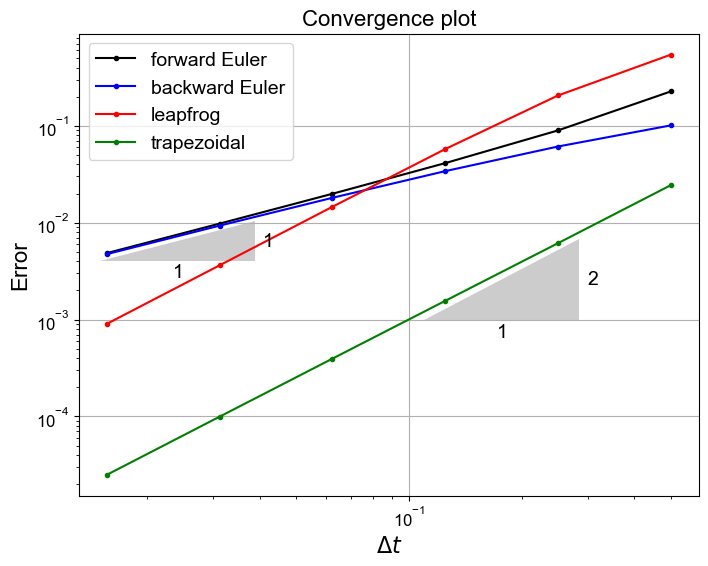

In [5]:
# define physical parameter
K = 2
# initial condition
y0 = 1
# and some numerical parameters
tend = 1.0
# the range of time step sizes we will consider
dts = [0.5/(2**n) for n in range(0, 6)]

def f(t, y):
    return -K*y

def y_ex(t):
    """ Function to evaluate the exact solution to the exponential decay problem with y_r=0
    """ 
    return y0*np.exp(-K*t)


# set up figure
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

# somewhere to store our errors for each time step size
FE_error = np.empty(len(dts))
BE_error = np.empty(len(dts))
leapfrog_error = np.empty(len(dts))
trap_error = np.empty(len(dts))

# loop over our different time step sizes, compute solution and corresponding error
for (i, dt) in enumerate(dts):
    # our time levels for the numerical solution
    N_dt = int(round(tend/dt))
    t = dt * np.linspace(0, N_dt, N_dt + 1)

    # forward Euler
    y = np.empty(len(t))
    y[0] = y0
    for (n, t_n) in enumerate(t[:-1]):
        # note for this example this is the same as y[n]*(1-dt*K)
        y[n+1] = y[n] + dt * f(t_n, y[n])

    FE_error[i] = np.linalg.norm(y - y_ex(t))/np.sqrt(len(y))

    # backward Euler
    y = np.empty(len(t))
    y[0] = y0
    for n in range(0, len(t) - 1):
        # for this simple problem we can rearrange the implicit expression
        # and hence do not need to use the f function - if we did we would
        # need to use an implicit equation solver.
        y[n+1] = y[n]/(1 + dt*K)

    BE_error[i] = np.linalg.norm(y - y_ex(t))/np.sqrt(len(y))

    # leapfrog
    y = np.empty(len(t))
    y[0] = y0
    y[1] = y[0] + dt*f(t[0], y[0])
    for n in range(1, len(t) - 1):
        y[n+1] = y[n-1] + 2.0 * dt * f(t_n, y[n])

    leapfrog_error[i] = np.linalg.norm(y - y_ex(t))/np.sqrt(len(y))

    # trapezoidal
    y = np.empty(len(t))
    y[0] = y0
    # note here FOR THIS TEST CASE we can write an amplification factor
    # outside the loop to save some computations, and help explain the
    # stability discussion below. We could have done likewise of the other
    # schemes of course.
    amp = (1.0 - K*dt/2.0) / (1.0 + K*dt/2.0)
    for n in range(0, len(t) - 1):
        y[n+1] = y[n] * amp

    trap_error[i] = np.linalg.norm(y - y_ex(t))/np.sqrt(len(y))

axs.loglog(dts, FE_error, 'k.-', label='forward Euler')
axs.loglog(dts, BE_error, 'b.-', label='backward Euler')
axs.loglog(dts,leapfrog_error,'r.-',label='leapfrog')
axs.loglog(dts, trap_error, 'g.-', label='trapezoidal')
axs.set_xlabel('$\Delta t$', fontsize=16)
axs.set_ylabel('Error', fontsize=16)
axs.set_title('Convergence plot', fontsize=16)
axs.grid(True)
axs.legend(loc='best', fontsize=14)
annotation.slope_marker((1.5e-2, 4e-3), (1, 1), ax=axs,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((1.1e-1, 1.0e-3), (2, 1), ax=axs,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

#### Comments


- We see that *for this problem* that forward and backward Euler are both first-order accurate and that their errors, at least in the asymptotic limit, are pretty much identical.


- Leapfrog and trapezoidal are both second-order accurate. 


- The oscillations we see with leapfrog are still present with smaller time step sizes, but we see from this error plot that they decay at a rate consistent with the overall second-order accuracy of the scheme. However, their presence clearly leads to higher errors in comparison to the trapezoidal scheme. Below a certain time step size, even though oscillations are present, the errors in leapfrog are less than for the first-order methods, but it performs worse at larger time step sizes.


- Note that the leapfrog scheme is popular in numerical weather prediction where *filters* have been developed to deal with the oscillatory issue we see above. Part of this popularity is the fact that it is a second-order scheme, while only needing once function evaluation per time step which minimises cost. This could be a big advantage if $f$ is very expensive to compute.

## Implementing implicit schemes

We've seen two implicit methods

- the **backward Euler** or **implicit Euler** method:

$$\frac{y_{n+1} - y_{n}}{\Delta t} = {f}(t_{n+1},{y}_{n+1}) \;\;\; \iff \;\;\; y_{n+1} - {\Delta t}\,{f}(t_{n+1},{y}_{n+1}) = y_{n}$$


<br>

- and the **trapezoidal** method:

$$
\begin{align*}
\frac{y_{n+1} - y_{n}}{\Delta t} & = \frac{1}{2}\left({f}(t_{n},{y}_{n}) + {f}(t_{n+1},{y}_{n+1})\right) \\[5pt] 
\iff \;\;\;  
 y_{n+1} - \frac{\Delta t}{2}{f}(t_{n+1},{y}_{n+1}) & =  y_{n} + \frac{\Delta t}{2}{f}(t_{n},{y}_{n}),
 \end{align*}
$$

<br>

<br>

We need to comment more on the implementation of these schemes in practice.


<br>

For the model problem

$$\frac{dy}{dt} = -K y$$

which is both linear and scalar, this is actually quite easy to deal with.

<br>

Backward Euler applied to this problem requires us to solve

$$y_{n+1} + {\Delta t}\,Kz, {y}_{n+1} = y_{n}$$

but we can just rearrange this to

$$y_{n+1} (1 +  {\Delta t}\,Kz) = y_{n} \implies 
y_{n+1} = \frac{1}{(1 +  {\Delta t}\,Kz)} = y_{n}
$$

which is exactly what we used in the code above.

<br>

For Trapezoidal we have 

$$y_{n+1} + \frac{\Delta t}{2} \, K\, {y}_{n+1}  =  y_{n} - \frac{\Delta t}{2} \, K \, {y}_{n}$$

which we can again easily rearrange to 

$$y_{n+1}\left(1 +  \frac{\Delta t}{2}\,  K\right)  =  y_{n}\left(1 -  \frac{\Delta t}{2}\,  K\right)
\implies
y_{n+1} =   \frac{\left(1 -  \frac{\Delta t}{2}\,  K\right)}{\left(1 +  \frac{\Delta t}{2}\,  K\right)}y_{n}
$$

<br>

<br>

Things get more complicated if we have a linear system (rather than scalar) of ODEs in which case the above manupulation is possible but requires the solution of a linear system.

If we are solving an ODE whose RHS function is nonlinear in $y$, then we can't use the trick used above of pulling out and dividing through by a factor, instead we need to make use of a nonlinear solver such as Newton's method.

The hardest case is where we have a system of nonlinear ODEs - then we need to use a nonlinear *system* solver.

## Using numerical quadrature

Another, essentially equivalent, way of thinking about how we can go about tackling our problem numerically is to start by integrating both sides of our ODE over a small interval $[t_{n},t_{n+1}]$ to yield (assuming again for notational simplicity that we have a scalar system):

$$
\begin{align*}
\int_{t_{n}}^{t_{n+1}}\frac{d{y}}{dt}\,dt &= \int_{t_{n}}^{t_{n+1}} {f}(t,{y}(t))\, dt \\[10pt]
\implies y_{n+1} - y_{n} &= \int_{t_{n}}^{t_{n+1}} {f}(t,{y}(t))\, dt,
\end{align*}
$$

where $y_{n+1}=y(t_{n+1})$ and $y_{n}=y(t_{n})$.

[Aside (notation clarification): At this point these are exact equalities in our notation since we haven't yet discretised the problem. If $y_{n}$ is exact, and we evaluate the integral exactly then this expression tells us $y_{n+1}$ exactly. But if $y_{n}$ is only approximate and/or we evaluate the integral only approximately, then the new $y_{n+1}$ will only be an approximation to the true solution].

If we introduce the notation

$$\bar{f} := \frac{1}{\Delta t} \int_{t_{n}}^{t_{n+1}} {f}(t,{y}(t))\, dt,$$

where $\Delta t = t_{n+1} - t_{n}$ (note we're assuming here that the time step size is constant - this won't always be the case and so we will use the notation $\Delta t_{n}$ when needed), then we have

$$\frac{y_{n+1} - y_{n}}{\Delta t} = \bar{f}.$$ 


From its definition we can see that $\,\bar{f}\,$ is the average of $\,f\,$, equivalently the average gradient of $\,y\,$ (the gradient being given by ${f}(t,{y}(t))$), over the interval $t\in [t_{n},t_{n+1}]$.

<br>

There are lots of ways that we can estimate/approximate the average gradient $\bar{f}$, each of which leads to a different time-stepping scheme with different costs, accuracy, orders of convergence, etc.

The simplest approach to estimating $\,\bar{f}\,$ (the average value of $f$ over the interval $[t_{n},t_{n+1}]$) is just to take its value at the start of this interval (cf. a variant of the midpoint quadrature rule from previous lectures), i.e. to take 

$$\bar{f} \equiv \frac{1}{\Delta t} \int_{t_{n}}^{t_{n+1}} {f}(t,{y}(t))\, dt \approx \frac{1}{\Delta t} \,{\Delta t} \, {f}(t_{n},{y}_{n}) =  {f}(t_{n},{y}_{n}), $$

in which case our time-stepping scheme becomes 

$$\frac{y_{n+1} - y_{n}}{\Delta t} = {f}(t_{n},{y}_{n}) \;\;\; \iff \;\;\; {y_{n+1} - y_{n}} = {\Delta t}\; {f}(t_{n},{y}_{n}),$$

which we recognise as the *forward Euler*, or *explicit Euler* method introduced previously.

We can similarly derive the backward Euler, leapfrog and trapezoidal schemes - think about these schematically and in terms of quadrature rules.

We can therefore derive a number of schemes either through thinking about numerical differentiation (equivalently through Taylor series analysis) or via the integral based derivation above and choices of different quadrature schemes to evaluate $\bar{f}$.

## Errors

## Definitions (errors)

### Local truncation error

The *local truncation error* (LTE; or often just *truncation error*) is defined, and computed, by *substituting the exact solution to the problem into the numerical scheme*.

[Note that this definition requires that the numerical scheme is scaled such that it approximates the derivatives in the differential equations, i.e. in the form 

$$\frac{y_{n+1}-y_{n}}{\Delta t} = \ldots \;\;\;\;  \text{not}  \;\;\;\; y_{n+1} = y_{n} + \Delta t \times \ldots.$$

Be warned though: some people don't make this a requirement and so the powers of $\Delta t$ flying around in their analysis will be one out compared to us!]

For forward Euler for example the LTE ($\tau$) therefore takes the form

$$\tau := \frac{y(t_{n+1})-y(t_{n})}{\Delta t}- \boldsymbol{f}\,(t,\boldsymbol{y}\,(t)).$$

By construction (up to round-off errors) the numerical solution satisfies this relation exactly (i.e. the terms of the RHS balance out), but this will not in general be true for the *exact solution* and so the above quantity will not be zero, and this discrepancy is termed the LTE.

<br>

<br>

Using the notation $y_n=y(t_n)$, Taylor series tells us that

$$ y_{n+1} = y_n + \Delta ty'_n + \frac{\Delta t^2}{2!}y''_n + \frac{\Delta t^3}{3!}y'''_n + \mathcal{O}(\Delta t^4),$$

and since $y'_n = f(t_n,y_n)$, this tells us that

$$ \tau = \frac{y_{n+1} -  y_n}{\Delta t} - f(t_n,y_n) = \frac{\Delta t}{2!}y''_n + \frac{\Delta t^2}{3!}y'''_n + \mathcal{O}(\Delta t^3).$$


### Order of convergence & consistency

A scheme is said to have an *order of accuracy* (or a *convergence order*) of $p$ if 

$$ |\tau|\le C \Delta t ^p \;\;\;\; \text{as} \;\;\;\; \Delta t \longrightarrow 0, $$

(and this bound in not valid for any higher value of $p$), for some constant $C$.

An equivalent way to write this is $ \tau = \mathcal{O}(\Delta t^p)$.

A method is called *consistent* if the LTE converges to zero as $\Delta t$ tends to zero. Note that this is equivalent to having a convergence order $p>0$.

Recall our discussion in a previous lecture on estimating convergence orders of algorithms via finding the slopes of lines on log-log plots - we will do this exact thing here where we plot $\tau$ against $\Delta t$.


<br>

<br>

Based on the above Taylor series analysis we can say that the forward Euler method has a leading order term in its local truncation error of order $\mathcal{\Delta t}$ and so is consistent, with an order of accuracy ($p$) of one.

### Local error

Assuming previous time levels are known exactly, the *local error* can be defined as the error committed by the numerical method in one time step. As we shall see below, it is equal to the LTE multiplied by the time step size. 

Or said another way the LTE is the local error per time step.

<br>

<br>

In the case of forward Euler, if we assume that $y_n=y(t_n)$, i.e. the numerical solution is exact at time level $n$, then one step forward of the numerical method satisfies

$$ y_{n+1} = y_n + \Delta t\, f(t_n,y_n),$$

whereas the true solution satisfies

$$ y(t_{n+1}) = y_n + \Delta ty'_n + \frac{\Delta t^2}{2!}y''_n + \frac{\Delta t^3}{3!}y'''_n + \mathcal{O}(\Delta t^4),$$

the difference $y(t_{n+1}) - y_{n+1}$ is thus

$$\text{Local error} = \frac{\Delta t^2}{2!}y''_n + \mathcal{O}(\Delta t^3),$$

which is consistent with what we said above:  the local error is the "LTE multiplied by the time step size":

$$\text{Local error} = \Delta t \, \times \, \tau$$


### Global error

The *global error* was given in the definition of convergence above:

$$E := \max_{t_0 \, \le \, t_n \, \le \, T}\| \boldsymbol{y}_{n} - \boldsymbol{y}\,(t_{n})\|.$$

[Recall that convergence was defined as $E \longrightarrow 0$ as $\Delta t \longrightarrow 0$.]


### Links between errors and stability

Note that consistency alone does not imply convergence of the overall scheme as defined above. 

Instead

> Consistency $+$ Stability $\iff$ Convergence


## Stability

Recall that we said that stability of a numerical solver is established by considering when does a continuous (linear) model problem converge to zero, or diverge to infinity, and when does a numerical solver exhibit consistent behaviour when applied to the same linear model problem.

## Continuous case

The linear model problem we need to consider is 

$$\frac{dz}{dt} = \lambda z, $$

where we need to consider the case where $\lambda$ is a complex number.

This has the exact solution

$$z(t) = z(0) \text{e}^{\lambda\,t}. $$


<br>


The important thing to note is that the long-term solution behaviour of this problem is governed by whether or not $\lambda$ is greater than or less than zero: 


- if $\lambda>0$ then $z \longrightarrow\infty$,


- if $\lambda<0$ then $z \longrightarrow 0$,


- if $\lambda=0$ then $z \equiv z(0)$,


as $t\longrightarrow\infty$.

You could of course write some code to check this for a few examples.

**Aside:** Now you might be thinking that while that may be interesting, this is a special (linear) case and so how useful can this be in general. Well it turns out that consideration of this simple case is extremely valuable and tells us a lot about more complex (e.g. nonlinear) problems as well. See Section 7.4.3 of LeVeque's book on finite difference methods.

However, it is very important that we extend the above analysis to systems (i.e. vector problems with more than one component):

## Discrete case

To analyse the stability of our numerical method we perform a similar analysis. 

Or said another way, we ask the question: how does the act of discretising the problem change the solution behaviour we found above for this test problem? 

[We will see that the answer to this question is dependent on the underlying problem's physical parameters (which here in this abstract test problem are all encoded within the $\,\lambda\,$ parameter), but is also a function of numerical parameters such as the time step size $\Delta t$].

The forward Euler scheme applied to our model problem takes the form

$$\frac{{z}_{n+1}-{z}_{n}}{\Delta t} = \lambda z_{n}\;\;\;\iff\;\;\;
z_{n+1} = (1+\lambda\Delta t)z_{n}. $$


The solution of this sequence can be written in terms of the initial condition as

$$z_{n} = (1+\lambda\Delta t)^{n} z_0,$$

which clearly tends to zero provided 

$$\left|\;1+\lambda\Delta t\;\right|<1,$$ 

(this quantity can be termed the *amplification factor* for the scheme). 

Substituting $\lambda=\lambda_R + i\lambda_I$, we have the stability condition

$$\sqrt{(1+\lambda_R\Delta t)^2 + (\lambda_I\Delta t)^2}<1.$$

[For the absolute value of a complex number see: <https://en.wikipedia.org/wiki/Absolute_value#Complex_numbers>].

For the case of forward Euler the stable region can therefore be visualised as a circle in the complex plane centred at $(-1,0)$ with radius 1, with the quantities $\lambda_R\Delta t$ and $\lambda_I\Delta t$ on the $x$ and $y$ axes.

Note that this is significantly more restrictive than the continuous case (which for stability simply required that $\,\lambda_R<0$), and for larger eigenvalues $\lambda$ requires a smaller time step size $\Delta t$ to ensure stability.

Let's plot both of these stability regions:

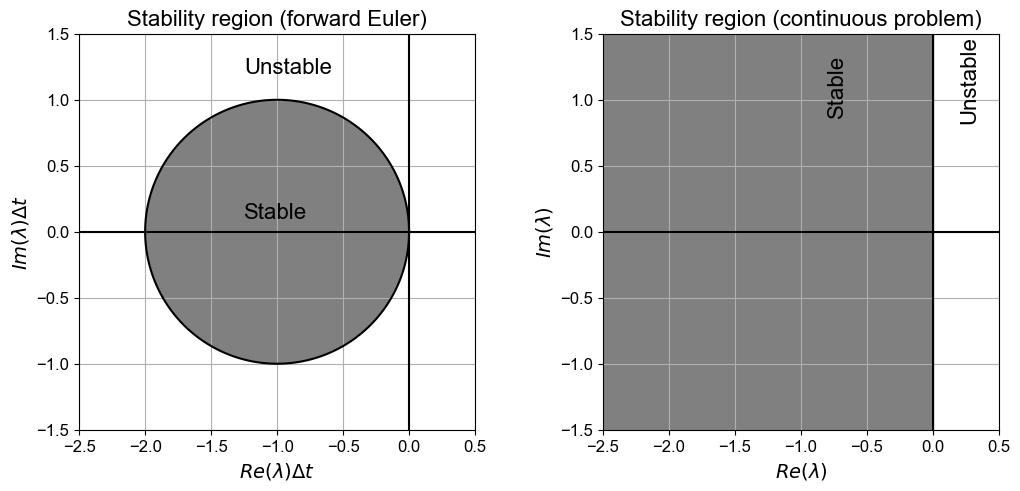

In [6]:
# let's try calculating and plotting the stability region for the discrete (FE) and continuous problems

# set up a mesh in x,y, sufficiently fine to get a nice image, with the bounds chosen appropriately
x = np.linspace(-2.5, 0.5, 100)
y = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x, y)

# define a complex parameter which is our  lambda * dt  quantity
lamdt = xx + 1j*yy

# compute the "amplification factor" for the forward Euler scheme
amp = 1 + lamdt

# and its magnitude - we want this to be less than one for stability
ampmag = np.abs(amp)

# set up our figs for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
fig.tight_layout(w_pad=5)  # add some padding otherwise axes labels overlap

# plot the forward Euler stability region
ax1.contour(x, y, ampmag, [1.0], colors=('k'))
ax1.contourf(x, y, ampmag, (0.0, 1.0), colors=('grey'))
ax1.set_aspect('equal')
ax1.grid(True)
ax1.set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=14)
ax1.set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=14)
ax1.set_title('Stability region (forward Euler)', fontsize=16)
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
ax1.text(-1.25, 0.1, 'Stable', fontsize=16)
ax1.text(-1.25, 1.2, 'Unstable', fontsize=16)

# as we didn't do it previously let's also plot the stability region for the continuous problem
# note no dt in the axis labels as "timestep" is meaningless in the continuous world
ax2.axvspan(-3, 0, color='grey')
ax2.set_xlim(-2.5, 0.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.grid(True)
ax2.set_xlabel(r'$Re(\lambda)$', fontsize=14)
ax2.set_ylabel(r'$Im(\lambda)$', fontsize=14)
ax2.set_title('Stability region (continuous problem)', fontsize=16)
ax2.axhline(y=0, color='k')
ax2.axvline(x=0, color='k')
ax2.text(-0.8, 0.9, 'Stable', fontsize=16, rotation=90)
ax2.text(0.2, 0.85, 'Unstable', fontsize=16, rotation=90);

We can similarly derive an amplification factor for our other three initial simple schemes, plots of which look like the following:

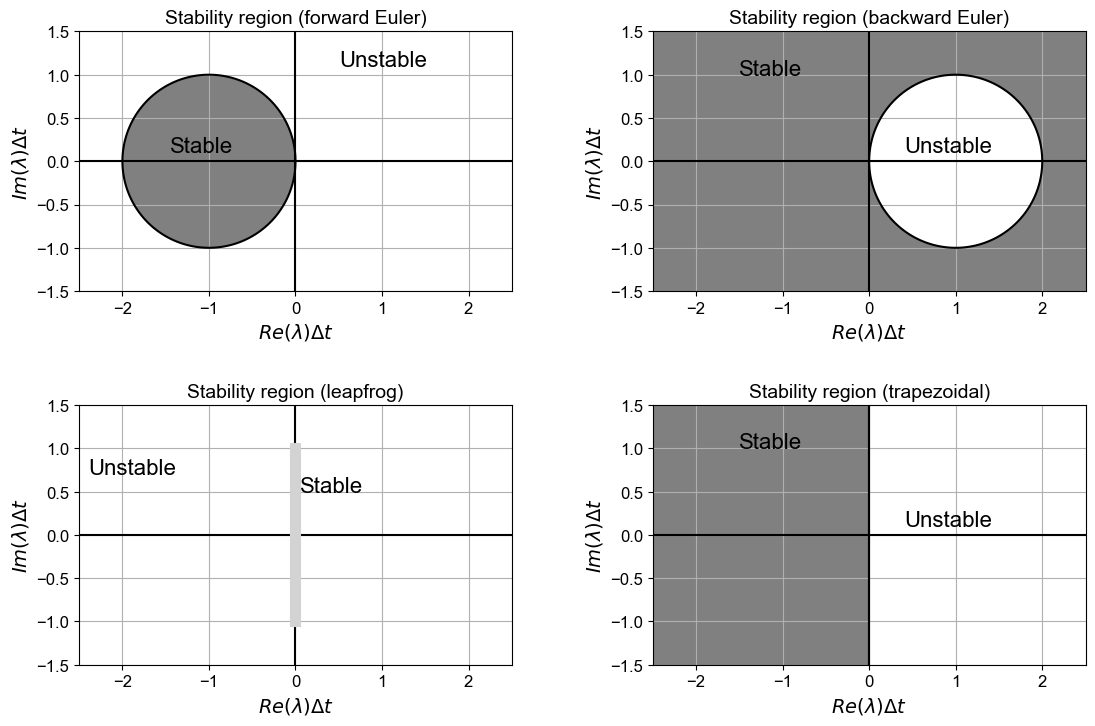

In [7]:
# let's calculate and plot the stability region for our discrete schemes
x = np.linspace(-2.5, 2.5, 250)
y = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x, y)
lamdt = xx + 1j*yy

# forward Euler amplification factor,  and its magnitude
FEamp = 1 + lamdt
FEampmag = np.abs(FEamp)

# backward Euler amplification factor,  and its magnitude
BEamp = 1.0/(1 - lamdt)
BEampmag = np.abs(BEamp)

# trapezoidal amplification factor,  and its magnitude
trapamp = (1.0 + lamdt/2.0) / (1.0 - lamdt/2.0)
trapampmag = np.abs(trapamp)

# set up our figs for plotting
fig, axs = plt.subplots(2, 2, figsize=(11, 7))
fig.tight_layout(w_pad=5, h_pad=5)
# reshape the list of axes as we are going to use in a loop
axs = axs.reshape(-1)

# plot the forward Euler stability region
axs[0].contour(x, y, FEampmag, [1.0], colors=('k'))
axs[0].contourf(x, y, FEampmag, (0.0, 1.0), colors=('grey'))
axs[0].set_aspect('equal')
axs[0].grid(True)
axs[0].set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
axs[0].set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
axs[0].set_title('Stability region (forward Euler)', fontsize=14)
axs[0].axhline(y=0, color='k')
axs[0].axvline(x=0, color='k')
axs[0].text(-1.45, 0.1, 'Stable', fontsize=16)
axs[0].text(0.5, 1.1, 'Unstable', fontsize=16)

# plot the backward Euler stability region
axs[1].contour(x, y, BEampmag, [1.0], colors=('k'))
axs[1].contourf(x, y, BEampmag, (0.0, 1.0), colors=('grey'))
axs[1].set_aspect('equal')
axs[1].grid(True)
axs[1].set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
axs[1].set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
axs[1].set_title('Stability region (backward Euler)', fontsize=14)
axs[1].axhline(y=0, color='k')
axs[1].axvline(x=0, color='k')
axs[1].text(-1.5, 1.0, 'Stable', fontsize=16)
axs[1].text(0.4, 0.1, 'Unstable', fontsize=16)

# plot the leapfrog stability region
axs[2].set_aspect('equal')
axs[2].grid(True)
axs[2].set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
axs[2].set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
axs[2].set_title('Stability region (leapfrog)', fontsize=14)
axs[2].axhline(y=0, color='k')
axs[2].axvline(x=0, color='k')
axs[2].axvline(x=0, ymin=1./6., ymax=5./6., color='lightgrey', lw=8)
axs[2].set_xlim((-2.5, 2.5))
axs[2].set_ylim((-1.5, 1.5))
axs[2].text(0.05, 0.5, 'Stable', fontsize=16); 
axs[2].text(-2.4, 0.7, 'Unstable', fontsize=16)

# plot the trapezoidal stability region
axs[3].contour(x, y, trapampmag, [1.0], colors=('k'))
axs[3].contourf(x, y, trapampmag, (0.0, 1.0), colors=('grey'))
axs[3].set_aspect('equal')
axs[3].grid(True)
axs[3].set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
axs[3].set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
axs[3].set_title('Stability region (trapezoidal)', fontsize=14)
axs[3].axhline(y=0, color='k')
axs[3].axvline(x=0, color='k')
axs[3].text(-1.5, 1.0, 'Stable', fontsize=16)
axs[3].text(0.4, 0.1, 'Unstable', fontsize=16);

#### Comments


- Recall that the stability region for the *continuous problem* is given by $Re(\lambda)<0$, so ideally we would like the numerical scheme to be consistent with this, if it isn't we need to choose our time step size carefully to ensure stability (and for some schemes note that this may not be possible).


- Backward Euler's stability region *contains* that of the continuous problem and so the scheme is termed **unconditionally stable** - this analysis indicates that the scheme should be stable (for problems with  $Re(\lambda)<0$) no matter how large we choose $\Delta t$.


- This is also the case for the trapezoidal scheme.


- Note however that the backward Euler stability region is actually *larger* than for the continuous problem. E.g. this means that even for a positive (real component of) $\lambda$ (for which while of course the exact solution, being an exponential, goes off to infinity), our analysis indicates that if we choose a large enough $\Delta t$ backward Euler will be stable - but what does this mean in practice? - See the example directly below.


- Leapfrog (as a two step method) is a bit more complicated. As we saw above the method possesses a "spurious mode", this grows with time when excited and hence the method is unstable, except in situations where this "mode" is never initially excited. This is the case when the eigenvalues of the problem are purely imaginary, as indicated in the above stability region plot. Filters do exist to periodically kill off the spurious mode and make the method usable for more general applications. We won't go into any more detail on this, but if interested search for "Robert-Asselin time filter".


### Backward Euler excess stability test

We should say more about what Backward Euler and what it means for its stability region to be larger than that of the continuous problem.

Let's consider a continuous problem whose true solution behaviour involves exponential growth to infinity, and see what happens if we use FE and BE on this case with a relatively large time step size.

(-1.0, 10.0)

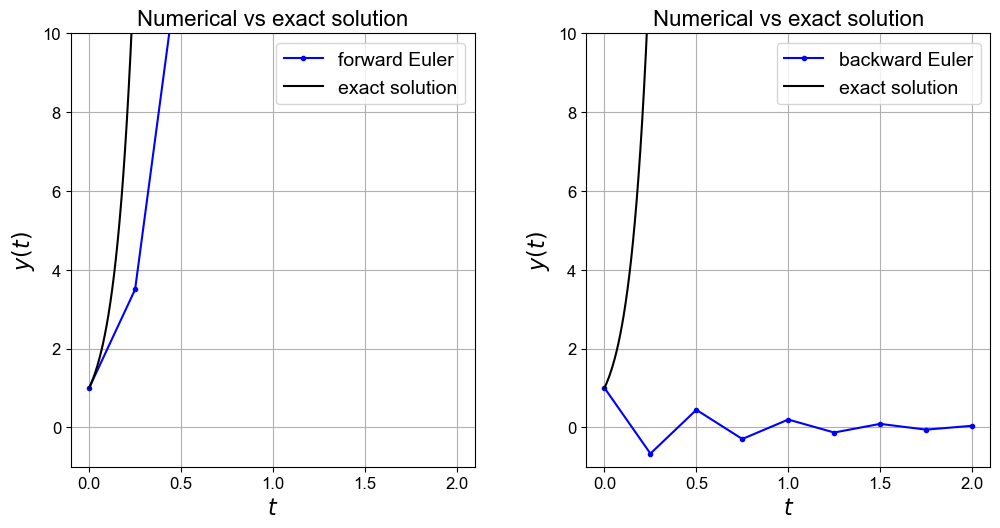

In [8]:
# choosing K to be negative means that the true solution goes off to infinity
K = -10
y0 = 1
dt = 0.25  # also try dt = 0.15 which would place us inside the "unstable circular region" for BE
tend = 2.0

def f(t, y):
    return -K*y

def y_ex(t):
    """ Function to evaluate the exact solution to the exponential decay problem with y_r=0
    """ 
    return y0*np.exp(-K*t)

# let's use a finer resolution to plot the exact solution 
# to give a smooth curve in our plot
tfine = np.arange(0, tend, dt/100)

# set up figure with 4 subplots to plot our 4 methods
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=4)

# our time levels for the numerical solution
N_dt = int(round(tend/dt))
t = dt * np.linspace(0, N_dt, N_dt + 1)
# an alterntive would be two use
# t = np.arange(0, tend, dt)
# but round-off means that can miss the tend value
# alternatively we could use something like
# t = np.arange(0, tend+1.e-10, dt)
# but the 1.e-10 increment needs to be relative

# a time loop to implement forward Euler
y = np.empty(len(t))
y[0] = y0
for (n, t_n) in enumerate(t[:-1]):
    # note for this example this is the same as C[n]*(1-dt*K)
    y[n+1] = y[n] + dt * f(t_n, y[n])

axs[0].plot(t, y, 'b.-', label='forward Euler')
axs[0].plot(tfine, y_ex(tfine), 'k', label='exact solution')
axs[0].set_xlabel('$t$', fontsize=16)
axs[0].set_ylabel('$y(t)$', fontsize=16)
axs[0].set_title('Numerical vs exact solution', fontsize=16)
axs[0].grid(True)
axs[0].legend(loc='best', fontsize=14)
axs[0].set_ylim([-1,10])

# backward Euler
y = np.empty(len(t))
y[0] = y0
for n in range(0, len(t) - 1):
    # note that for this simple problem we can rearrange the 
    # implicit expression and hence do not need to use the 
    # f function - if we did we would need to use an 
    # implicit equation solver such as was introduced in L4
    y[n+1] = y[n]/(1 + dt*K)

axs[1].plot(t, y, 'b.-', label='backward Euler')
axs[1].plot(tfine, y_ex(tfine), 'k', label='exact solution')
axs[1].set_xlabel('$t$', fontsize=16)
axs[1].set_ylabel('$y(t)$', fontsize=16)
axs[1].set_title('Numerical vs exact solution', fontsize=16)
axs[1].grid(True)
axs[1].legend(loc='best', fontsize=14)
axs[1].set_ylim([-1,10])

So note that it is BE here that is actually the one that's displaying spurious behaviour - the solution is spuriously damped to the degree that it does not tend to infinity as it should.

Smaller time step sizes here will result in it recovering the correct qualitative behaviour.

## Absolute stability

Note that this form of stability is actually termed **absolute stability** and is concerned with *practical limitations* on time step sizes which give reasonable numerical results - i.e. for a given problem (e.g. here for a given value of $\lambda$) the choice of a time step size $\Delta t$ that places us inside that schemes stability region. 

And even before we get to that point, importantly this concept also gives us a means to select an appropriate time stepping scheme which allows us to use a reasonable time step.

<br>

Below, the concept of **zero stability** will also be introduced.

<br>

Note that although an absolute stability analysis is based on consideration of a linear test problem it is also generally of significant use in determining appropriate time step sizes for nonlinear problems, see LeVeque - FD - Section 7.4.3 for a discussion of this point. We also commented on this fact in the previous lecture.

For forward Euler we state the method is absolutely stable provided the time step is chosen such that $|1+\lambda\Delta t| \le 1$ (we call the region of the complex plane where this is true the ***region of absolute stability***); otherwise it is unstable.

<br>

### "A" stability / A-stable methods

For a method such as backward Euler (and trapezoidal) where its region of absolute stability contains all of the left hand complex plane, we call the method *A-stable*.


### A($\alpha$) stability [$\star$]

```{admonition} Optional Content
:class: dropdown
For many problems the eigenvalues (i.e. the $\lambda$'s in the above stability analysis) have large negative real parts, but relatively small imaginary parts.  

For these types of problems we don't actually need schemes which contain the entire negative complex plane in their region of absolute stability (i.e. not fully A-stable), rather we would like the negative real axis and a certain region either side of it to be in the region of absolute stability. 

Methods which have a region of absolute stability that encompass a *wedge* extending to the left from the origin with angles $\alpha$ above and below the real axis are termed A($\alpha$)-stable (so full A-stability is the same as A($\pi/2$)-stability or  A($90$)-stability).

BDF methods we introduce near the end of this lecture have this property.
```



## L-stability [$\star\star$]
```{admonition} Advanced Content
:class: dropdown

L-stability is a stronger property than full A-stability which is sometimes useful for problems with very large eigenvalues.

Consider backward Euler and the Trapezoidal scheme which are both A-stable and so we should be able to take an arbitrarily large time step size and remain stable for problems where the real part of $\lambda$ is negative.

The amplification factors ($R(z)$ where $z:=\lambda\,\Delta t$) we used in the above code to plot their stability regions tell us we can write the two schemes as 

$$ z_{n+1}^{\text{(BE)}} = R(z)^{\text{(BE)}} z_{n}^{\text{(BE)}} \;\;\;\;\text{where}\;\;\;\; R(z)^{\text{(BE)}} = \frac{1}{1-z},$$

and 

$$ z_{n+1}^{\text{(TR)}} = R(z)^{\text{(TR)}} z_{n}^{\text{(TR)}} \;\;\;\;\text{where}\;\;\;\; R(z)^{\text{(TR)}} = \frac{1+\tfrac{1}{2}z}{1-\tfrac{1}{2}z}.$$

But consider what happens in the limit of $|z|\longrightarrow\infty$, i.e. as the time step size increases to infinity: 

- $|R(z)^{\text{(BE)}}| \longrightarrow 0$ and we have the correct qualitative behaviour in our solution;


- $|R(z)^{\text{(TR)}}| \longrightarrow 1$, so while the solution does not diverge, it does not converge to the correct solution.

We would therefore say that BE is L-stable while Trap is not.
```

```{admonition} Advanced Content
:class: dropdown
#### Example

Let's see an example of this. 

Consider the problem

$$y'(t) = \lambda(y - \cos(t)) - \sin(t), \;\;\;\; y(0) = y_0.$$

The exact solution to this problem is 

$$y(t) = \text{e}^{\lambda t}(y_0 - 1) + \cos(t).$$

Notice that the initial condition $y_0 = 1$ leads to the simple solution $y(t) = \cos(t)$. 

However, for other initial conditions the additional term $\text{e}^{\lambda t}(y_0 - 1)$ is non-zero. Clearly in the case of a negative real $\lambda$ parameter this term decays to zero, i.e. solutions with initial condition $y_0 \ne 1$ converge to the solution $y(t) = \cos(t)$.

If $\lambda$ is large then this initial "transient" will be very short-lived. Let's suppose that it is the long term behaviour we want to simulate accurately. Well for a start explicit methods are out as we would need to choose a very small time step size to be in the stability region. But BE and TR are both A-stable so should be reasonable choices shouldn't they? Let's check this.


Confirming this behaviour is a homework exercise. Note that reducing the time step does not help. This problem with the trapezoidal scheme does not manifest if we start with the initial condition $y_0=1$.
```

```{figure} Figures/L-stability_example.png
:width: 75%
```


## Time-stepping errors

Recall from a previous lecture on numerical integration that we performed a mathematical analysis to compute local quadrature errors over each sub-interval, and then summed these to calculate/estimate a global error for composite schemes over the total interval we cared about.

As we see from the discussion above, we can think of time here as being the equivalent of this integration interval, and hence approximation of the integral over each sub-interval introduces a *local error*, but now in the time-stepping case we cannot simply sum these to compute a global error as we use the numerical solution (which contains all the errors up to that point), to compute the next step along the solution trajectory. Thus errors *accumulate* and we need to take this into account in our analysis.


## A little bit of maths to bound the global error  [$\star\star$]

```{admonition} Advanced Content
:class: dropdown

Recall our definition of global error:

$$E := \max_{t_0\, \le \, t_n \, \le \, T}\| {y}_{n} - {y}(t_{n})\|.$$

As the global error 'accumulates' this (the maximum value over all time levels) may well be the error at the final time, but it is also possible for some errors to cancel out, or for a long term trend to be accurately captured by the solver and thus for the errors to actually decrease at later times, hence the maximum error may not necessarily be at the final time.  We saw an example of this previously where the forward Euler scheme seemed to converge to the correct solution in the exponential decay/relaxation problem, even though there were large errors at early and intermediate times.

Let's define the error at an arbitrary time level as

$$E_n := {y}_{n} - {y}(t_{n}).$$

Let's assume we are solving our linear model problem

$$ y' = \lambda y, \;\;\;\;\;\; y(0)=y_0,$$

with forward Euler, and so we have the relation for the discrete solution

$$y_{n+1} = y_n + \Delta t f(t_n,y_n) = (1+\lambda\Delta t)y_n.$$

The local truncation error from the previous lecture tells us about the exact continuous solution

$$
\begin{align*}
& \;\;\;\; \tau_{n} := \frac{y(t_{n+1}) -  y(t_n)}{\Delta t} - f(t_n,y(t_n))\\[10pt] 
\iff\;\;\;\; & \;\;\;\;
y(t_{n+1}) =  y(t_n) + \Delta t  f(t_n,y(t_n)) - \Delta t  \tau_{n}\\[10pt] 
\iff\;\;\;\; & \;\;\;\;
y(t_{n+1}) =  (1+\lambda\Delta t)y(t_n)  - \Delta t  \tau_{n},
\end{align*}
$$

(the final term emphasising the comment from the previous lecture that the local error is the LTE multiplied by the time step size).

Subtracting we have

$$
\begin{align*}
E_{n+1} := {y}_{n+1} - {y}(t_{n+1}) & = y_n + \Delta t f(t_n,y_n) - \left[y(t_n) + \Delta t  f(t_n,y(t_n)) - \Delta t  \tau_{n}\right] \\[10pt] 
& = (1+\lambda\Delta t)y_n - (1+\lambda\Delta t)y(t_n) +  \Delta t  \tau_{n}\\[10pt]
& = (1+\lambda\Delta t) ( y_n - y(t_n)) +  \Delta t  \tau_{n}
\\[10pt]
& = (1+\lambda\Delta t) E_n +  \Delta t  \tau_{n},
\end{align*}
$$

this gives us a recursive relation for the global error, which additionally demonstrates the effect of the local truncation error at every time step. 

[If it helps you could think about a financial analogue here - $E$ being your savings, $\lambda\Delta t$ an interest rate, with $\Delta t  \tau_{n}$ then being an additional investment made each period - cf. a homework exercise form L4].

This is true for all $n$, and so we can expand it out backwards as follows:

$$
\begin{align*}
E_{n+1} & = (1+\lambda\Delta t) E_n +  \Delta t  \tau_{n}\\[10pt] 
& = (1+\lambda\Delta t) [ (1+\lambda\Delta t) E_{n-1} +  \Delta t  \tau_{n-1} ]  +  \Delta t  \tau_{n}\\[10pt] 
& = (1+\lambda\Delta t) [ (1+\lambda\Delta t) \{ (1+\lambda\Delta t) E_{n-2} +  \Delta t  \tau_{n-2} \} +  \Delta t  \tau_{n-1} ]  +  \Delta t  \tau_{n}.
\end{align*}
$$

If we continue this all the way back to the start of the time-stepping iteration we would clearly be left with an $E_0$ term (i.e. to account for any potential error in our representation of the exact initial condition), along with a sum of the truncation errors at each time level multiplied by the appropriate power of the amplification factor [we've also taken the opportunity here to replace $n+1$ with $n$, which we can do as $n$ is arbitrary]:

$$ E_{n} = (1+\lambda\Delta t)^{n} E_0 + \Delta t\sum_{i=1}^{n} (1+\lambda\Delta t)^{n-i}\tau_{i-1}. $$

[Again you may find it helpful to think about the financial analogue mentioned above and this being a form of "compounding".]

Since $\,|1+\lambda\Delta t| \le e^{\,|\lambda|\, \Delta t}\,$ (which follows from $\,e^{\,|\lambda|\, \Delta t} = 1 + |\lambda|\, \Delta t + (|\lambda|\, \Delta t)^2/2 + \ldots$), we know that

$$  |1 + \Delta t \lambda|^{n  - i} \leq e^{\,(n-i)\, \Delta t\, |\lambda|} \leq e^{\,n\,\Delta t\, |\lambda|} = e^{\,|\lambda| \, T}\;\;\;\;\;\text{and similarly} \;\;\;\;\;  
|1 + \Delta t \lambda|^{n} \leq  e^{\,|\lambda| \, T},
$$

where $T = n\Delta t$ is the end point of our integration.

Therefore taking the absolute value of our error estimate we can establish the following *bound* on our error:

$$
\begin{align*} 
|E_{n}| 
& \le  e^{\,|\lambda|\, T} \left( |E_0| + \Delta t 
\sum_{i=1}^{n} |\tau_{i-1}|\right)\\[10pt]
& \le  e^{\,|\lambda|\, T} \left( |E_0| + n\Delta t \max_{1\le i\le n}|\tau_{i-1}| \right)
= e^{\,|\lambda|\, T} \left( |E_0| + T \max_{1\le i\le n}|\tau_{i-1}| \right)
\end{align*}
$$

We know from the previous lecture that the LTE for forward Euler is, for any $n$,

$$ \tau_n = \frac{y_{n+1} -  y_n}{\Delta t} - f(t_n,y_n) = \frac{\Delta t}{2!}y''_n + \mathcal{O}(\Delta t^2),$$

and if we assume the initial error $|E_0|$ is zero (i.e. we are given and use an exact initial condition) then

$$|E_{n}| \le  
e^{\,|\lambda|\, T} T  \max_{1\le i\le n}|\tau_{i-1}| 
=  e^{\,|\lambda|\, T} T \left( \frac{\Delta t}{2}\,\max |y''| + \mathcal{O}(\Delta t^2)\right),$$

and hence the method converges at the same order as the LTE, i.e. the global error is first-order in $\Delta t$.

```



#### Comments


- A key thing to note here is that the global error is the same order as the LTE, hence a truncation error analysis also tells us about the expected convergence order globally (although we showed this for forward Euler, this result holds more generally for all stable schemes).


- The $e^{\,|\lambda|\, T} T$ factor grows with $T$ and hence the global error can only get larger the larger time interval we consider.


- The size of the global error is also a function of an appropriate derivative of the solution $y$ (here for a first-order scheme this is the second derivative that came from the definition of the LTE) - more complex or sharply varying problems would be expected to have larger global errors.


- Note that essentially nothing changes if this analysis was instead performed on the model problem

$$ y' = \lambda y + g(t),$$

(see LeVeque (FD book) sections 6.2, 6.3.1).



- Also, as long as $f$ is well-behaved then the same analysis holds for nonlinear problems (LeVeque section 6.3.3, 7.4.3), with $\lambda$ essentially replaced by (a bound on) the derivative of $f$ w.r.t. $y$ (or more generally the eigenvalues of the Jacobian matrix).



- See also LeVeque - Chapter 6 for similar results for more general time-stepping schemes.




## Zero stability  [$\star\star$]

```{admonition} Advanced Content
:class: dropdown

Note that the one-step error at step $m$: $\,\Delta t\tau_m$, contributes the term introduced in the $m$-th step: $(1+\lambda\Delta t)^{n-m}\Delta t\tau_m$ to the global error. 

Since the factor $(1+\lambda\Delta t)^{n-m}$ is bounded (by $e^{\,|\lambda| \,T}$ - note this bound is independent of $\Delta t$) as we reduce the time step size, this tells us that each one step contribution to the global error is bounded. 

So although the local error can be amplified significantly by the exponential factor, and will grow with time, this factor is bounded independent of the time step size, and so does not impact on the *order of convergence* (in the asymptotic limit - this means that we might have to use an incredibly small time step to actually observe this convergence).

Hence, here for forward Euler the global error also converges at first order (in the asymptotic limit).


Note that the fact that individual local errors are bounded in their contribution to the global error is of course a desirable (vital!) condition, and is termed ***zero stability*** - one of several definitions of stability.

LeVeque - FD - section 6.4, example 6.2 gives an example of a time stepping scheme which although consistent (is first-order accurate) does not converge in general and so is, by definition, *not* zero stable.

Further to this, see LeVeque - FD - section 7.1 for an example of why a zero stable method can also give useless results for a *finite (i.e. practical)* value of the time step.

To establish whether a numerical method will produce reasonable results with a given finite time step size (and to guide us in the choice of a reasonable time step size), we need a different concept of stability. 

A common and practical example of this is termed ***absolute stability*** and was the flavour of stability we defined above and considered in the previous lecture (as well as the four 'simple' schemes introduced above) where we plotted forward Euler's stability region in the complex plane - we will return to this concept for some of our new (more advanced and higher order) schemes below.

```

## Practical choice of step size

NB. This text is taken essentially directly from LeVeque - FD - section 7.5:

" ... obtaining computed results that are within some error tolerance requires two conditions:

1. The time step $\Delta t$ must be small enough that the local truncation error is acceptably small. This gives a constraint of the form $\Delta t < \Delta t_{\text{acc}}$ ("acc" for accuracy), where $\Delta t_{\text{acc}}$ depends on several things:
   - What method is being used, which determines the expansion for the local truncation error;
   - How smooth the solution is, which determines how large the high order derivatives occurring in this (LTE) expansion are; and
   - What accuracy is required.


2. The time step $\Delta t$ must be small enough that the method is absolutely stable on this particular problem. This gives a constraint of the form $\Delta t < \Delta t_{\text{stab}}$ that depends on the magnitude and location of the eigenvalues of the Jacobian matrix $\,f'(y)\,$ [or our $\lambda$ above].



Typically we would like to choose our time step based on accuracy considerations, so we hope $\Delta t_{\text{stab}} > \Delta t_{\text{acc}}$. For a given method and problem, we would like to choose $\Delta t$ so that the local error in each step is sufficiently small that the accumulated error will satisfy our error tolerance, assuming some *reasonable* growth of errors. ....


If stability considerations force us to use a much smaller time step than the local truncation error indicates should be needed, then this particular method is probably not optimal for this problem. This happens, for example, if we try to use an explicit method on a "stiff" problem, for which special methods have been developed" [as discussed below]


## Linear multistep (LMS) methods

## Popular time-stepping schemes

Two very famous/popular families of time-stepping schemes are:


- [*Linear multistep (LMS) methods*](https://en.wikipedia.org/wiki/Linear_multistep_method)


- [*Runge-Kutta (RK) methods*](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)


They take fundamentally different approaches which have major implications for their implementations in code and suitability for different applications.

## Introduction - LMS

As an extension of the (four simple) example time-stepping schemes above, consider the most general linear relation between solutions spanning $k+1$ levels (termed a $k$-step method):

$$\sum_{j=0}^k \alpha_j \, y_{n+j} = \Delta t \sum_{j=0}^k \beta_j \, f(t_{n+j},y_{n+j}).$$


- Note that we can generally divide through by $\alpha_k$, i.e. normalise, and hence simply assume that $\alpha_k=1$. This helps emphasise that this is a scheme designed to calculate $y_{n+k}$ using the previous $k$ time levels.


- The second thing to note is that if $\beta_k=0$ then the corresponding method is explicit,


- if $\beta_k\ne 0$ then the corresponding method is implicit. 


- Since multistep methods make use of information from previous time levels this information needs to be stored for the appropriate number of future time levels. This is not the case with all methods, as we shall see later, and thus the LMS approach does come at the cost of memory usage.


- The *Adams* methods we will introduce now make the choice $\alpha_k=1$, $\alpha_{k-1}=-1$, with the rest of the $\alpha$ parameters chosen to be zero; the $\beta$ parameters are then chosen to maximise the order of accuracy of the particular scheme. For explicit methods we need $\beta_k=0$ and the remaining $k$ coefficients can be chosen such that the method has order $k$. For implicit methods we can go one order higher.


Not every method can be written in this form, consider for example the improved Euler method introduced at the end of the previous lecture (although note that IE can be interpreted as a predictor-corrector type of LMS method - see below).


## Explicit linear multistep methods - Adams-Bashforth schemes

So-called *Adams* schemes can be thought of as methods which start from the expression we saw above linking time stepping to quadrature:

$$y_{n+1} - y_{n} = \int_{t_{n}}^{t_{n+1}} {f}(t,{y}(t))\, dt.$$ 

The LHS is in the form of the general LMS expression written above, with $\alpha_k=1$, $\alpha_{k-1}=-1$.

The $\{\beta_j\}$ coefficients are then chosen such that the RHS of the general LMS expression in the cell above approximates the integral on the RHS of this expression.

By using information from more and more previous time levels (i.e. increasing $k$), we can approximate the integral to increasing accuracies, and this consequently leads to a family of time-stepping schemes of increasing accuracy. 

[This doesn't really map onto any of the approaches we saw in our lecture on quadrature as there we never used information from outside a (sub-)interval under consideration. The motivation to do this here comes from the fact that we have information (function evaluations) from previous time levels and so seek to make use of this.]

<br>

The ***Adams-Bashforth schemes*** are the **explicit** variants of the Adams family - we enforce $\beta_k=0$ so that the function evaluated at the newest time level does not appear on the RHS.

The first four schemes in this family are:

$$
\begin{align*}
k=1\; \textrm{(1-step AB scheme):} \;\;\;  y_{n+1} &= y_{n} +\Delta t  f_{n} \\
k=2\; \textrm{(2-step AB scheme):} \;\;\;  y_{n+2} &= y_{n+1} + \frac{\Delta t}{2}\; (-f_{n} + 3 f_{n+1}) \\
k=3\; \textrm{(3-step AB scheme):} \;\;\;  y_{n+3} &= y_{n+2} + \frac{\Delta t}{12}\; (5 f_{n} - 16 f_{n+1} + 23 f_{n+2}) \\
k=4\; \textrm{(4-step AB scheme):} \;\;\;  y_{n+4} &= y_{n+3} + \frac{\Delta t}{24}\; (-9 f_{n} + 37 f_{n+1} -59 f_{n+2} + 55 f_{n+3})
\end{align*}
$$

where to save space we have introduced the notation $f_{j}:=f(t_j,y_j)$.


- Notice that the 1-step scheme in this family is *forward Euler*.


- Notice that the leapfrog scheme is an example of an explicit LMS scheme, just NOT of Adams type.


- The order of accuracy of these schemes is equal to $k$.


- Note that as these expressions are valid for all $n$ (apart from at the start, as per the *self-starting* comment above), we can rewrite them all to provide formulae for the $(n+1)$-th time level, e.g. we could equivalently write:

$$
\begin{align*}
k=4\; \textrm{(4-step AB scheme):} \;\;\;  y_{n+1} &= y_{n} + \frac{\Delta t}{24} (55 f_{n} -59 f_{n-1} + 37 f_{n-2} -9 f_{n-3})
\end{align*}
$$


## Adams-Bashforth scheme - sketch of derivation [$\star$]
```{admonition} Optional Content
:class: dropdown

Here we sketch how the above schemes can be derived [another example is in the homework exercises].

Consider as an example $k=2$, i.e. the two-step method (in the form where the newest time level we are solving for is level $\,n+1$):

$$y_{n+1} - y_n = \Delta t \left( \beta_0 \, f_{n-1} + \beta_1 \, f_n \right) \approx  \int_{t_{n}}^{t_{n+1}} {f}(t,{y}(t))\, dt,$$

where we want to choose $\beta_0$ and $\beta_1$ such that we have a good approximation to the integral.

We considered the accuracy (or degree of precision) of quadrature rules in Lecture 2 by asking that our rule exactly integrated polynomials of up to some degree.  The $k=1$ forward Euler scheme integrates exactly constant ($p=0$) polynomials. With two free parameters, $\beta_0$ and $\beta_1$, let's ask that our $k=2$ scheme is exact for polynomials of degree 0 and 1.

Recall from L2 that we can do this by considering the monomials $f(t) = t^p$ for $p = 0$ and 1. 

To make things a little easier we can assume that $t_{n-1} = -\Delta t,\; t_n = 0$, $t_{n+1} = \Delta t$:

$$
\begin{align*}
  f(t)\equiv 1: \;\;\;\; \int_{t_{n}}^{t_{n+1}} \, dt & = \Delta t  = \Delta t \left( \beta_0  + \beta_1 \right) \;\;\;\; \implies \;\;\;\; 1 =  \beta_0  + \beta_1  , \\[10pt]
  f(t)\equiv t: \;\;\;\; \int_{t_{n}}^{t_{n+1}} t\, dt & = \frac{\Delta t^2}{2}  = \Delta t \left(-\Delta t \,\beta_0 \right) \;\;\;\; \implies \;\;\;\; \frac{1}{2} = -\beta_0  .
\end{align*}
$$

This gives a system two simultaneous equations we can trivially solve to yield $\beta_0=-1/2$ and $\beta_1=3/2$, which is indeed the AB2 scheme given in the cell directly above:


$$y_{n+1} = y_{n} + \Delta t \left( \beta_0 \, f_{n-1} + \beta_1 \, f_n \right) = y_{n} + \frac{\Delta t}{2}\; (-f_{n-1} + 3 f_{n}).$$
 

By extending this analysis to more free parameters $\{\beta_j\}$, and higher-order polynomials, we can derive all the AB schemes - see the homework exercise where we do this for AB4.

Note than an alternative derivation that arrives at the same scheme involves replacing the integral of $f$ on the RHS with the integral of the Lagrange interpolating polynomial that passes through the function values at the appropriate time levels. Different order schemes then result from different order interpolating polynomials (equivalently number of time levels considered).

```

## Implicit linear multistep methods - Adams-Moulton schemes

The ***Adams-Moulton schemes*** are the **implicit** variants of the Adams family - they are very similar to the AB schemes in that the same 'Adams' constraint applies to the $\alpha$ parameters, but now  $\beta_k\ne 0$, and hence the schemes are all *implicit*. 

The first five schemes in this family are:

$$
\begin{align*}
"k=0"\; \textrm{(1-step AM scheme):} \;\;\;  y_{n+1} &= y_{n} +{\Delta t}\; f_{n+1} \\
k=1\; \textrm{(1-step AM scheme):} \;\;\;  y_{n+1} &= y_{n} +\frac{\Delta t}{2}\; (f_{n} + f_{n+1}) \\
k=2\; \textrm{(2-step AM scheme):} \;\;\;  y_{n+2} &= y_{n+1} + \frac{\Delta t}{12}\; (-f_{n} + 8 f_{n+1} + 5f_{n+2}) \\
k=3\; \textrm{(3-step AM scheme):} \;\;\;  y_{n+3} &= y_{n+2} + \frac{\Delta t}{24}\; (f_{n} - 5 f_{n+1} + 19 f_{n+2} + 9 f_{n+3}) \\
k=4\; \textrm{(4-step AM scheme):} \;\;\;  y_{n+4} &= y_{n+3} + \frac{\Delta t}{720}\; (-19 f_{n} + 106 f_{n+1} - 264 f_{n+2} + 646 f_{n+3} + 251 f_{n+4})
\end{align*}
$$


- Note that both the $"k=0"$ and the $k=1$ schemes use information from two time levels, and so both can be termed 1-step methods (i.e. they both *step* from $n$ to $n+1$).


- Note that the $k=0$ scheme is *backward Euler*,


- and the $k=1$ scheme is *trapezoidal* (both seen at the start of this lecture).


- The order of accuracy of these schemes is equal to $k+1$ (one higher than AB for the same $k$ as we have an additional parameter to play with here).


- We can re-write the schemes to provide formulae for an update at time level $n+1$, e.g.:

$$k=3\; \text{(3-step AM scheme):} \;\;\;  y_{n+1} = y_{n} + \frac{\Delta t}{24}\; (
9 f_{n+1} + 19 f_{n} - 5 f_{n-1}  + f_{n-2}).$$




## Linear Multistep Methods - error analysis and consistency/order conditions  [$\star\star$]
```{admonition} Advanced Content
:class: dropdown

Through the derivations above (and in homework) we've seen that, by construction, the methods are consistent with a given order of accuracy (since they are based on a consistent approximation to the integral in the integrated form of the ODE).

But let's also see what an explicit derivation of the truncation error tells us.

The general from of LMS schemes is given by

$$\sum_{j=0}^k \alpha_j \, y_{n+j} = \Delta t \sum_{j=0}^k \beta_j \, f(t_{n+j},y_{n+j}),$$

and hence the local truncation error for LMS schemes is defined by [recall we stipulated in our definition of the LTE that the scheme needs to be scaled so that it matches the ODE - so we need to divide above by the time step]:

$$\tau := \frac{1}{\Delta t}\left[ \sum_{j=0}^k \alpha_j \, y(t_{n+j}) - \Delta t \sum_{j=0}^k \beta_j \, y'(t_{n+j})\right],$$

where we have replaced the numerical solution $y_{n+j}$ with the exact solution $y(t_{n+j})$ and used the fact that for the exact solution $f(t_{n+j},y(t_{n+j})) = y'(t_{n+j})$.

Taylor series tells us that 

$$ y(t_{n+j}) = y(t_n) + j\Delta t\, y'(t_n) + \frac{j^2\Delta t^2}{2!}y''_n + \mathcal{O}(\Delta t^3),$$

with derivative

$$ y'(t_{n+j}) = y'(t_n) + j\Delta t\, y''(t_n) + \frac{j^2\Delta t^2}{2!}y'''_n + \mathcal{O}(\Delta t^3).$$

Substituting into the truncation error expression above and collecting terms yields

$$
\begin{align*}
\tau = \frac{1}{\Delta t}\left( \sum_{j=0}^k \alpha_j \right)y(t_n)
+ \left( \sum_{j=0}^k (j\alpha_j - \beta_j)\right)y'(t_n)
& + \Delta t\left( \sum_{j=0}^k \left(\frac{1}{2}j^2\alpha_j - j\beta_j\right)\right)y''(t_n)\\[10pt]
+ \ldots
& + \Delta t^{q-1}\left( \sum_{j=0}^k \left(\frac{1}{q!}j^q\alpha_j - \frac{1}{(q-1)!}j^{q-1}\beta_j\right)\right)y^{(q)}(t_n) \\[10pt]
& + \ldots.
\end{align*}
$$

For the method to be consistent we need that $\tau=\mathcal{O}(\Delta t^p)$ where $p$ is at least one. 

Hence, for an LMS scheme to be consistent we require that the first two terms in the above expansion be zero, i.e.

$$\sum_{j=0}^k \alpha_j = 0 \;\;\;\;\;\;\;\text{and}\;\;\;\;\;\;\;
\sum_{j=0}^k j\alpha_j =  \sum_{j=0}^k\beta_j.$$

Note further that if we choose the coefficients such that the first $p+1$ terms vanish then the methods will the $p$-th order accurate.

For *Adams* methods specifically to be consistent (as $\alpha_k=1$, $\alpha_{k-1}=-1$, and all the other $\alpha$ parameters are zero, the first relation is clearly satisfied) we need 

$$\sum_{j=0}^k\beta_j = \sum_{j=0}^k j\alpha_j = k - (k-1) = 1.$$

In the cell below we can check that this is true, as well as the coefficients of even higher order terms to confirm that AB4 and AM3 are indeed both fourth oder accurate.
```


In [9]:
from math import factorial

#AB4 coefficients
AB4_alphas = np.array([0., 0., 0., -1., 1.])
AB4_betas = np.array([-9./24., 37./24, -59./24., 55./24., 0.])
print(AB4_betas.sum())
print('AB4_betas.sum(): ', AB4_betas.sum())
print('Hence AB4 is consistent: ', np.isclose(1., AB4_betas.sum()))


#AM3 coefficients
AM3_alphas = np.array([0., 0., -1., 1.])
AM3_betas = np.array([1./24., -5./24.,  19./24., 9./24.])
print('\nAM3_betas.sum(): ',AM3_betas.sum())
print('Hence AM3 is consistent: ', np.isclose(1.,AM3_betas.sum()))

# while we're at it test the higher order terms:

# first order terms
print('\nFirst-order coefficient for AB4: ',np.sum([ (0.5*j**2*AB4_alphas[j] - j*AB4_betas[j]) for j in range(len(AB4_alphas))]))
print('First-order coefficient for AM3: ',np.sum([ (0.5*j**2*AM3_alphas[j] - j*AM3_betas[j]) for j in range(len(AM3_alphas))]))

# second order terms
print('\nSecond-order coefficient for AB4: ',np.sum([ (1./factorial(3))*j**3*AB4_alphas[j] - (1./factorial(2)*j**2*AB4_betas[j]) for j in range(len(AB4_alphas))]))
print('Second-order coefficient for AM3: ',np.sum([ (1./factorial(3))*j**3*AM3_alphas[j] - (1./factorial(2)*j**2*AM3_betas[j]) for j in range(len(AM3_alphas))]))

# third order terms
print('\nThird-order coefficient for AB4: ',np.sum([ (1./factorial(4))*j**4*AB4_alphas[j] - (1./factorial(3)*j**3*AB4_betas[j]) for j in range(len(AB4_alphas))]))
print('Third-order coefficient for AM3: ',np.sum([ (1./factorial(4))*j**4*AM3_alphas[j] - (1./factorial(3)*j**3*AM3_betas[j]) for j in range(len(AM3_alphas))]))

# fourth order terms
print('\nFourth-order coefficient for AB4: ',np.sum([ (1./factorial(5))*j**5*AB4_alphas[j] - (1./factorial(4)*j**4*AB4_betas[j]) for j in range(len(AB4_alphas))]))
print('Fourth-order coefficient for AM3: ',np.sum([ (1./factorial(5))*j**5*AM3_alphas[j] - (1./factorial(4)*j**4*AM3_betas[j]) for j in range(len(AM3_alphas))]))

0.9999999999999998
AB4_betas.sum():  0.9999999999999998
Hence AB4 is consistent:  True

AM3_betas.sum():  1.0
Hence AM3 is consistent:  True

First-order coefficient for AB4:  0.0
First-order coefficient for AM3:  4.440892098500626e-16

Second-order coefficient for AB4:  0.0
Second-order coefficient for AM3:  0.0

Third-order coefficient for AB4:  -1.7763568394002505e-15
Third-order coefficient for AM3:  4.440892098500626e-16

Fourth-order coefficient for AB4:  0.3486111111111132
Fourth-order coefficient for AM3:  -0.026388888888888795


#### Comments

- So AB4 and AM3 are both expected to be fourth-order accurate (as for both schemes the first, second and third order terms are zero (to round-off), while the fourth order term is non zero.

## Linear Multistep Methods - Predictor-Corrector approach

Note that to avoid the problem of needing to solve an implicit system to realise an Adams-Moulton (i.e. an implicit LMS) scheme, a standard approach is to use replace the  function evaluation at the newest time levels (i.e. $f_{n+k}$) on the RHS of the AM methods, with an approximation based on substituting in a value for this obtained from an explicit AB method, i.e. computing an estimate, or a *prediction*, of the solution $y_{n+k}$, calling this $y^*$, and substituting in $f(t_{n+k}, y^*)$ into the AM formula, and solving the resulting now explicit relation for a new, or *corrected*, $y_{n+k}$.

<br>

Notice that the combination of AB1 (forward Euler) with AM2 (trapezoidal) as a predictor-corrector pair, is exactly the method introduced in the Comp Math ODE lecture and variously known as 
*explicit trapezoidal*/*Euler-trapezoidal*,  [*Heun's*](https://en.wikipedia.org/wiki/Heun%27s_method), or the *improved/modified Euler's* method:

$$
\begin{align*}
    y^* &= y_{n} + \Delta t {f}(t_{n},{y}_{n}), \\[10pt]
    y_{n+1} &= y_{n} + \frac{1}{2} \Delta t \left({f}(t_{n},{y}_{n}) + {f}(t_{n+1},{y}^*)\right).
\end{align*}
$$

<br>

Another popular example of a predictor-corrector pair based upon LMS methods (but not of Adams type) is the Milne or Milne-Simpson method: <http://mathworld.wolfram.com/MilnesMethod.html>.

### Stability of predictor-corrector methods

Since the overall method is explicit a PC pair cannot have as large a stability region as the implicit scheme on its own.

As an example, improved Euler is made up of AB1 (forward Euler) and AM1 (trapezoidal) whose stability regions are plotted near the start of this lecture.  It turns our that this pair can also be interpreted as the method RK2 described shortly, and whose stability region is plotted a little later in this context - you will see that the stability region is somewhere in between that of AB1 and AM1 (a little larger than AB1 in the imaginary direction, but no-where near as large as the A-stable AM1!)

## Linear Multistep Methods - stability

We won't go through the derivation of the following absolute stability regions for the AB and AM families of the LMS schemes, but will plot them via the code below.  

Note that the lowest order AB and AM methods are the same as schemes we plotted the stability region for above. Also note that AM1 is the trapezoidal scheme, whose stability region we also plotted above, and so we omit this in the plots below in the interests of space.

If interested in the formal derivations for the expressions that yield these plots, and more on LMS stability in general, see LeVeque - FD section 7.3 and 7.6 for details.

Notice that the stability regions decrease in size significantly as we move to higher order - why does this perhaps make some sense if we think back to the use of high order and equal interval sizes in Lectures 1 and 2?

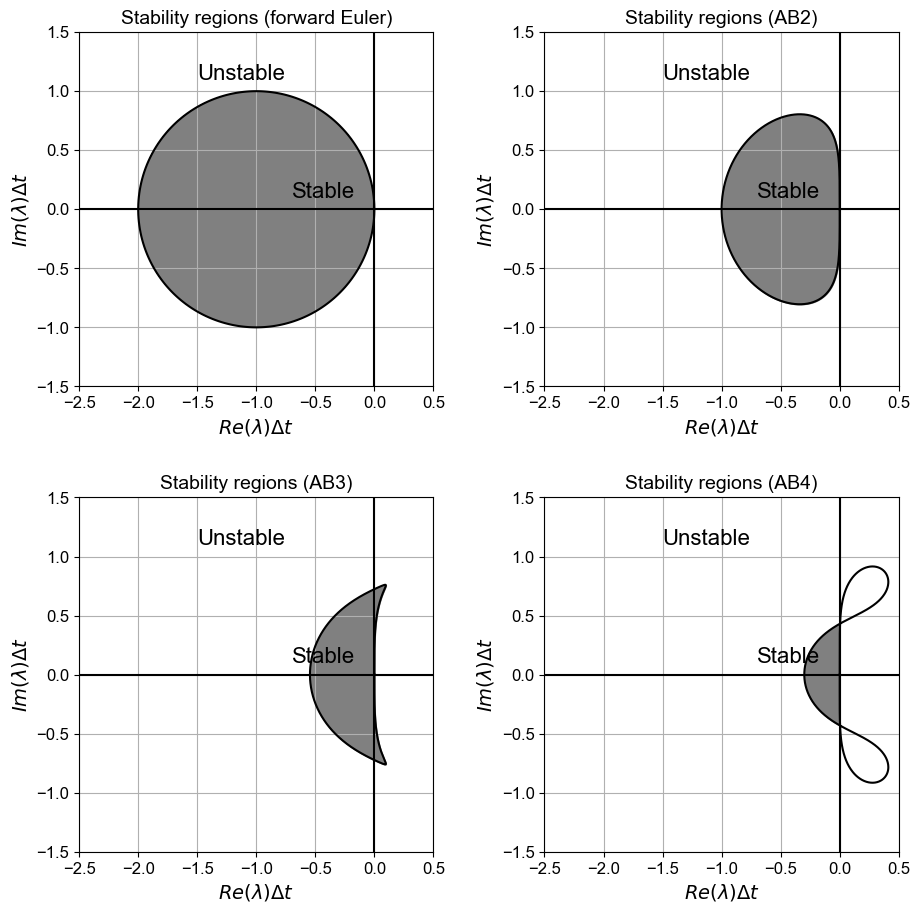

In [10]:
# let's calculate and plot the stability region for our discrete schemes (AB)

x = np.linspace(-2.5, 0.5, 250)
y = np.linspace(-1.5, 1.5, 100)
xx, yy = np.meshgrid(x, y)
lamdt = xx + 1j*yy

# forward Euler amplification factor,  and its magnitude
FEamp = 1 + lamdt
FEampmag = np.abs(FEamp)

# backward Euler amplification factor,  and its magnitude
BEamp = 1.0/(1 - lamdt)
BEampmag = np.abs(BEamp)

# trapezoidal amplification factor,  and its magnitude
trapamp = (1.0 + lamdt/2.0) / (1.0 - lamdt/2.0)
trapampmag = np.abs(trapamp)

# set up our figs for plotting
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
fig.tight_layout(w_pad=4, h_pad=4)
# reshape the list of axes as we are going to use in a loop
axs = axs.reshape(-1)

# plot the forward Euler stability region
axs[0].contour(x, y, FEampmag, [1.0], colors=('k'))
axs[0].contourf(x, y, FEampmag, (0.0, 1.0), colors=('grey'))

def add_fig_niceties(ax, title):
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
    ax.set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlim([-2.5, 0.5])
    ax.set_ylim([-1.5, 1.5])
    ax.text(-0.7, 0.1, 'Stable', fontsize=16)
    ax.text(-1.5, 1.1, 'Unstable', fontsize=16)
    
add_fig_niceties(axs[0],'Stability regions (forward Euler)')

# plot the AB2 stability region
theta = np.linspace(0., 2.*np.pi, 1000)
e_i_theta = np.exp(1j*theta)

rho = lambda e_i_theta: 2. * (e_i_theta - 1.) * e_i_theta
sigma = lambda e_i_theta: 3. * e_i_theta - 1.

z = rho(e_i_theta) / sigma(e_i_theta)

axs[1].plot(z.real, z.imag, 'k')
axs[1].fill_between(z.real, z.imag, color=('grey'))
add_fig_niceties(axs[1],'Stability regions (AB2)')

# plot the AB3 stability region
rho = lambda e_i_theta: 12. * (e_i_theta**3 - e_i_theta**2)   
sigma = lambda e_i_theta: 23. * e_i_theta**2 - 16. * e_i_theta + 5.

z = rho(e_i_theta) / sigma(e_i_theta)

axs[2].plot(z.real, z.imag, 'k')
axs[2].fill_between(z.real, z.imag, color=('grey'))
add_fig_niceties(axs[2],'Stability regions (AB3)')

# plot the AB4 stability region
rho = lambda e_i_theta: 24. * (e_i_theta**4 - e_i_theta**3) 
sigma = lambda e_i_theta: 55. * e_i_theta**3 - 59. * e_i_theta**2 + 37. * e_i_theta - 9.

z = rho(e_i_theta) / sigma(e_i_theta)

axs[3].plot(z.real, z.imag, 'k')
axs[3].fill_between(z.real[z.real<0], z.imag[z.real<0], color=('grey'))
add_fig_niceties(axs[3],'Stability regions (AB4)')



## plot the AB5 stability region
#rho = lambda e_i_theta: 720. * (e_i_theta**5 - e_i_theta**4) 
#sigma = lambda e_i_theta: 1901. * e_i_theta**4 - 2774. * e_i_theta**3 + 2616. * e_i_theta**2 - 1274. * e_i_theta + 251.
#z = rho(e_i_theta) / sigma(e_i_theta)
#axs[4].plot(z.real, z.imag, 'k')
#axs[4].fill_between(z.real[z.real<0], z.imag[z.real<0], color=('grey'))# where=[z.real<0],
#add_fig_niceties(axs[4],'Stability regions (AB5)')

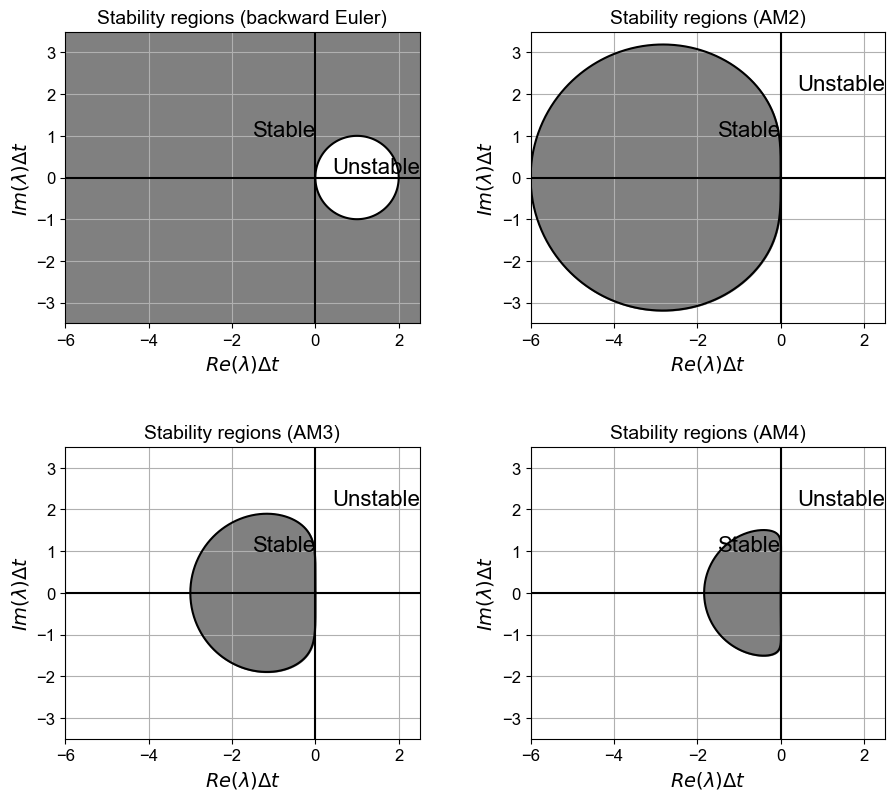

In [11]:
# let's calculate and plot the stability region for our discrete schemes (AM)

x = np.linspace(-6, 2.5, 700)
y = np.linspace(-3.5, 3.5, 700)
xx, yy = np.meshgrid(x, y)
lamdt = xx + 1j*yy

# forward Euler amplification factor,  and its magnitude
FEamp = 1 + lamdt
FEampmag = np.abs(FEamp)

# backward Euler amplification factor,  and its magnitude
BEamp = 1.0/(1 - lamdt)
BEampmag = np.abs(BEamp)

# trapezoidal amplification factor,  and its magnitude
trapamp = (1.0 + lamdt/2.0) / (1.0 - lamdt/2.0)
trapampmag = np.abs(trapamp)

# set up our figs for plotting
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
fig.tight_layout(w_pad=4, h_pad=4)
# reshape the list of axes as we are going to use in a loop
axs = axs.reshape(-1)

# plot the backward Euler stability region
axs[0].contour(x, y, BEampmag, [1.0], colors=('k'))
axs[0].contourf(x, y, BEampmag, (0.0, 1.0), colors=('grey'))
axs[0].text(-1.5, 1.0, 'Stable', fontsize=16)
axs[0].text(0.4, 0.1, 'Unstable', fontsize=16)
    
def add_fig_niceties(ax, title):
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
    ax.set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlim([-6, 2.5])
    ax.set_ylim([-3.5, 3.5])
    
add_fig_niceties(axs[0],'Stability regions (backward Euler)')


# note that AM1 is the trapezoidal scheme


# plot the AM2 stability region
theta = np.linspace(0., 2.*np.pi, 1000)
e_i_theta = np.exp(1j*theta)

rho = lambda e_i_theta: 12. * (e_i_theta - 1.) * e_i_theta  
sigma = lambda e_i_theta: 5. * e_i_theta**2 + 8. * e_i_theta - 1.

z = rho(e_i_theta) / sigma(e_i_theta)

axs[1].plot(z.real, z.imag, 'k')
axs[1].fill_between(z.real, z.imag, color=('grey'))
add_fig_niceties(axs[1],'Stability regions (AM2)')
axs[1].text(-1.5, 1.0, 'Stable', fontsize=16)
axs[1].text(0.4, 2.1, 'Unstable', fontsize=16)

# plot the AM3 stability region
rho = lambda e_i_theta: 24. * (e_i_theta - 1.) * e_i_theta**2  
sigma = lambda e_i_theta: 9. * e_i_theta**3 + 19. * e_i_theta**2 - 5. * e_i_theta + 1.

z = rho(e_i_theta) / sigma(e_i_theta)

axs[2].plot(z.real, z.imag, 'k')
axs[2].fill_between(z.real, z.imag, color=('grey'))
add_fig_niceties(axs[2],'Stability regions (AM3)')
axs[2].text(-1.5, 1.0, 'Stable', fontsize=16)
axs[2].text(0.4, 2.1, 'Unstable', fontsize=16)

# plot the AM4 stability region
rho = lambda e_i_theta: 720. * (e_i_theta - 1.) * e_i_theta**3  
sigma = lambda e_i_theta: 251. * e_i_theta**4 + 646. * e_i_theta**3 - 264. * e_i_theta**2 +106. * e_i_theta - 19.

z = rho(e_i_theta) / sigma(e_i_theta)

axs[3].plot(z.real, z.imag, 'k')
axs[3].fill_between(z.real, z.imag, color=('grey'))
add_fig_niceties(axs[3],'Stability regions (AM4)')
axs[3].text(-1.5, 1.0, 'Stable', fontsize=16)
axs[3].text(0.4, 2.1, 'Unstable', fontsize=16);

## Runge-Kutta (RK) methods

As was already discussed in Computational Mathematics, Runge-Kutta (RK) methods are perhaps the most popular class of time-stepping schemes.  

Rather than using information from previous time levels to increase accuracy, they make use of *intermediate steps*, that is the RHS function is evaluated at locations in between $t_n$ and $t_{n+1}$. 

Hence they can be referred to as *intermediate step methods*.  

With RK methods these intermediate steps are often called *stages*.

## LMS vs RK methods

Before we even get into any details on RK methods, we can make a few comments based on the above description:


1. As a single step method, we do not have the self-starting issue we identified with LMS schemes. Indeed a RK method is often used to provide the initial data required to get an LMS method started.


2. As a single step it makes it easier to change the time step, i.e. to perform adaptive time-stepping.


3. An advantage of LMS schemes was that we can store and re-use function evaluations which mitigates some of the cost of moving to higher order schemes. This is a potential advantage if it is expensive to evaluate the function (e.g. if it comes from the spatial discretisation of a PDE), but of course does require storage. With RK methods, however, we cannot re-use this information as we move to the next time step.

## Two stage Runge-Kutta example (RK2) - aka improved Euler / explicit trapezoidal / Euler-trapezoidal / Heun's method [from Comp Math]

We saw above that the trapezoidal rule had good stability and accuracy properties, its drawback is that it's implicit and so in general requires the solution of a nonlinear and/or matrix system.

The scheme takes the form

$${y_{n+1} - y_{n}} = \frac{1}{2} {\Delta t} \left({f}(t_{n},{y}_{n}) + {f}(t_{n+1},{y}_{n+1})\right).$$

The problem is the ${y}_{n+1}$ on the RHS, but as we have already seen we can approximate this using forward Euler, and substitute this into the scheme, yielding the explicit 2 stage method:

$$
\begin{align*}
    y^* &= y_{n} + \Delta t {f}(t_{n},{y}_{n}), \\[10pt]
    y_{n+1} &= y_{n} + \frac{1}{2} \Delta t \left({f}(t_{n},{y}_{n}) + {f}(t_{n+1},{y}^*)\right).
\end{align*}
$$

The scheme is an explicit "2 stage" method which uses FE in the first stage (to give a "guess" ($y^*$) at the new solution), but then uses the result from this to evaluate a more accurate RHS to our ODE. 

<br>


This method is variously called the *explicit trapezoidal*/*Euler-trapezoidal* (as motivated by the above derivation), *Heun's*, or the *improved/modified Euler's* method.

It is an example of a *predictor-corrector* method, as commented on above.

However, it can also be considered as an example of a single step, multi-stage method, i.e. can also be interpreted as an explicit Runge-Kutta method.

[So note that there is some degree of overlap between time-stepping ODE solver families, with some simple schemes being interetable  in several different ways, and as examples of different families. This overlap lessens as we move to more complex, higher order schemes of course].

### RK2 - schematic visualisation of method

The figure below demonstrates what RK2 is doing for an ODE problem with RHS function  $\,f(t,{y}(t)) = y+t^3\,$ which has the  exact solution
$\,y(t) =  7\exp(t) - t^3 - 3t^2 - 6t - 6$.

NB. this problem is taken from the Wikipedia page on RK methods: <https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods>.

Exact solution:  3.027972799213316
RK2 approximation:  3.0


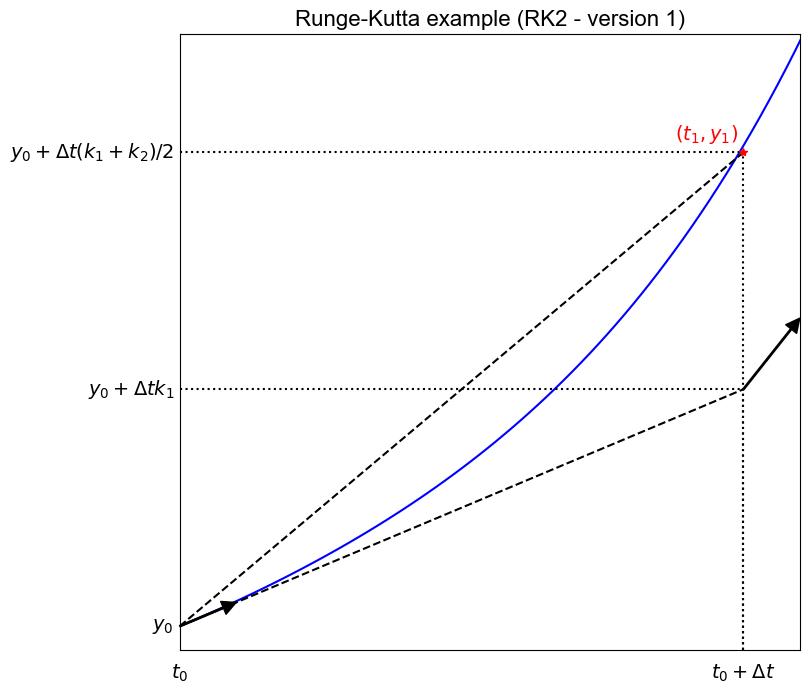

In [12]:
# example problem taken from Wikipedia entry on RK
def f(t, y):
    return y + t**3


def y(t):
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6


fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111)
ax1.set_title('Runge-Kutta example (RK2 - version 1)', fontsize=16)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([0,1.1])
ax1.set_ylim([0.9,3.5])
# define our x for plotting purposes
t = np.linspace(0, 1.5, 100)

# plot the exact solution
ax1.plot(t, y(t), 'b')

# initial time
t0 = 0.
# initial y
y0 = y(t0)
# example time step
dt = 1

# the stages k 
k1 = f(t0, y0)
k2 = f(t0 + dt, y0 + dt*k1)
y_new = y0 + dt*(1./2.)*(k1 + k2)

print('Exact solution: ', y(t0+dt))
print('RK2 approximation: ', y_new)

# length of the arrows indicating slopes
grad_length = 0.1
ax1.annotate("", xy=(t0+grad_length, y0+grad_length*k1), xytext=(t0, y0), arrowprops=dict(width=1, headlength=10, headwidth=10, facecolor='black'))
ax1.plot([t0, t0+dt], [y0, y0+dt*k1], 'k--')
ax1.annotate("", xy=(t0 + dt + grad_length, y0 + dt*k1 + grad_length*k2), xytext=(t0 + dt, y0 + dt*k1), arrowprops=dict(width=1, headlength=10, headwidth=10, facecolor='black'))
ax1.plot([t0, t0+dt], [y0, y0+dt*(1./2.)*(k1 + k2)], 'k--')

ax1.text(t0-0.01, y0, '$y_0$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.text(t0, 0.85, '$t_0$', horizontalalignment='center', verticalalignment='top', fontsize=14)
ax1.text(t0-0.01, y0+dt*k1, '$y_0+\Delta t k_1$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.text(t0+dt, 0.85, '$t_0+\Delta t$', horizontalalignment='center', verticalalignment='top', fontsize=14)
ax1.plot([t0, t0+dt], [y0+dt*k1, y0+dt*k1], 'k:')
ax1.plot([t0+dt, t0+dt], [-0.1, y0+dt*k1], 'k:')

ax1.text(t0-0.01, y0+dt*(1./2.)*(k1 + k2), '$y_0+\Delta t (k_1 + k_2)/2$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.plot([t0, t0+dt], [y0+dt*(1./2.)*(k1 + k2), y0+dt*(1./2.)*(k1 + k2)], 'k:')
ax1.plot([t0+dt, t0+dt], [-0.1, y0+dt*(1./2.)*(k1 + k2)], 'k:')
ax1.plot([t0+dt], [y0+dt*(1./2.)*(k1 + k2)], 'r*')
ax1.text(t0+dt-0.01, y0+dt*(1./2.)*(k1 + k2)+0.03, '$(t_1,y_1)$', color='r', horizontalalignment='right', verticalalignment='bottom', fontsize=14);

#### Comments

What is happening here?  These are the key steps in the code above:
```Python
# the stages k 
k1 = f(t0, y0)
k2 = f(t0 + dt, y0 + dt*k1)
y_new = y0 + dt*(1./2.)*(k1 + k2)
```


Let's match this up with the figure above ...



- $k_1$ gives the initial slope (function evaluation) and can be represented by the slope of the first black arrow.


- We use this to evaluate a new location given by the end point of the lower dashed line, at which we calculate $k_2$ - an estimate for the slope at this location further along the time step interval.  In the case of this particular two stage scheme, this is actually located at the new time level, but we will see examples later where intermediate locations within the time step are also or instead used.


- Using these two estimates for the slope (the two short black solid arrows), we derive a new estimate for the slope (the upper dashed line in the plot above, and for this particular scheme the simple average of the two $k$ values) and use this to actually provide the solution at the new time level - the red star.


- Note that the red star is not on the blue exact solution curve - there is an error introduced here.

## Another RK2 example (RK2 version 2) - aka explicit midpoint / modified Euler ... [from Comp Math]

Note that the *explicit two stage RK method* introduced above is not the only example of such a scheme.

If instead of trapezoidal, we start from the *implicit midpoint rule*:

$$
\begin{align*}
{y_{n+1} - y_{n}} &= {\Delta t}\, {f}\left(  \frac{1}{2} (t_{n}+t_{n+1}),\frac{1}{2} (y_{n}+y_{n+1})\right) \\[5pt] 
\iff \;\;
{y_{n+1} } &= y_{n} + {\Delta t}\, {f}\left(t_{n}+ \frac{\Delta t}{2} , \frac{1}{2} (y_{n}+y_{n+1}) \right),
\end{align*}
$$

we can similarly formulate an explicit two stage method:

$$
\begin{align*}
    y^* &= y_{n} + \frac{1}{2} \Delta t\, {f}(t_{n},{y}_{n}), \\[5pt] 
    {y_{n+1} } &= y_{n} + {\Delta t}\, {f}\left(t_{n}+ \frac{\Delta t}{2} , y^* \right).
\end{align*}
$$

This scheme is termed *explicit midpoint* and sometimes modified Euler (although be warned there is some re-use of the terms modified/improved Euler between explicit midpoint and explicit trapezoidal in the literature).

Let's plot a schematic of what this scheme is doing.

Exact solution:  3.027972799213316
RK2 (ver 2) approximation:  2.625


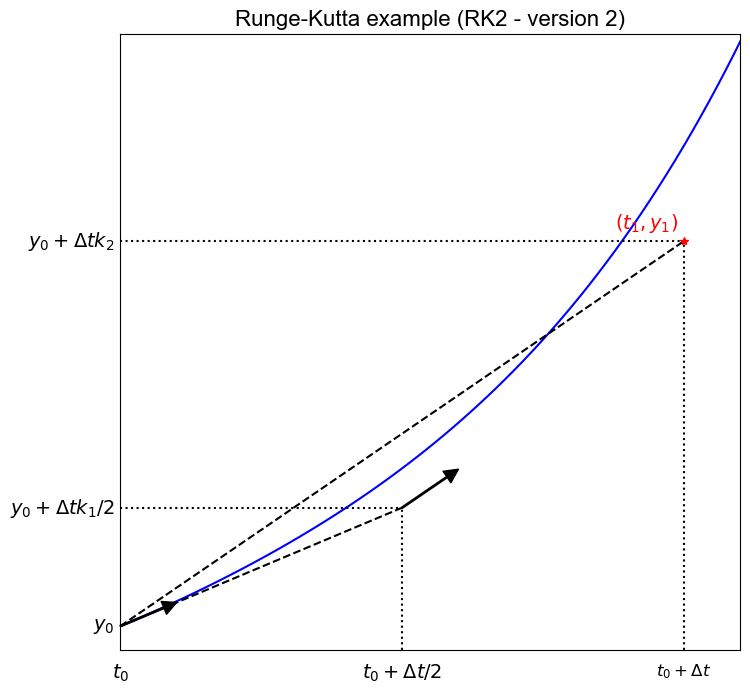

In [13]:
# example problem taken from Wikipedia entry on RK
def f(t, y):
    return y + t**3


def y(t):
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6


fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111)
ax1.set_title('Runge-Kutta example (RK2 - version 2)', fontsize=16)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([0,1.1])
ax1.set_ylim([0.9,3.5])
# define our t for plotting purposes
t = np.linspace(0, 1.5, 100)

# plot the exact solution
ax1.plot(t, y(t), 'b')

# initial time
t0 = 0.
# initial y
y0 = y(t0)
# example time step
dt = 1.

# the stages k 
k1 = f(t0, y0)
k2 = f(t0 + 0.5*dt, y0 + dt*0.5*k1)
y_new = y0 + dt*k2

print('Exact solution: ', y(t0+dt))
print('RK2 (ver 2) approximation: ', y_new)

# length of the arrows indicating slopes
grad_length = 0.1
ax1.annotate("", xy=(t0+grad_length, y0+grad_length*k1), xytext=(t0, y0), arrowprops=dict(width=1, headlength=10, headwidth=10, facecolor='black'))
ax1.plot([t0, t0+0.5*dt], [y0, y0+0.5*dt*k1], 'k--')
ax1.annotate("", xy=(t0 + 0.5*dt + grad_length, y0 + 0.5*dt*k1 + grad_length*k2), xytext=(t0 + 0.5*dt, y0 + 0.5*dt*k1), arrowprops=dict(width=1, headlength=10, headwidth=10, facecolor='black'))
ax1.plot([t0, t0+dt], [y0, y0+dt*k2], 'k--')

ax1.text(t0-0.01, y0, '$y_0$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.text(t0, 0.85, '$t_0$', horizontalalignment='center', verticalalignment='top', fontsize=14)
ax1.text(t0-0.01, y0+dt*0.5*k1, '$y_0+\Delta t k_1/2$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.text(t0+0.5*dt, 0.85, '$t_0+\Delta t/2$', horizontalalignment='center', verticalalignment='top', fontsize=14)
ax1.plot([t0, t0+0.5*dt], [y0+0.5*dt*k1, y0+0.5*dt*k1], 'k:')
ax1.plot([t0+0.5*dt, t0+0.5*dt], [-0.1, y0+0.5*dt*k1], 'k:')

ax1.text(t0-0.01, y0+dt*k2, '$y_0+\Delta t k_2$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.plot([t0, t0+dt], [y0+dt*k2, y0+dt*k2], 'k:')
ax1.plot([t0+dt, t0+dt], [-0.1, y0+dt*k2], 'k:')
ax1.text(t0+dt, 0.85, '$t_0+\Delta t$', horizontalalignment='center', verticalalignment='top')
ax1.plot([t0+dt], [y0+dt*k2], 'r*')
ax1.text(t0+dt-0.01, y0+dt*k2+0.03, '$(t_1,y_1)$', color='r', horizontalalignment='right', verticalalignment='bottom', fontsize=14);

#### Comments

For this method the key code is:
```Python
# the stages k 
k1 = f(t0, y0)
k2 = f(t0 + 0.5*dt, y0 + dt*0.5*k1)
y_new = y0 + dt*k2
```

- For this case $k_1$ is used to provide $k_2$ located at the mid point of the interval. 


- It is this slope estimate that is used directly to provide the final update to the solution at the new time level (i.e. we make no use of $k_1$ for the final update in this scheme).


- We see from both the plots, as well as the print outs of the exact vs the numerical solution for the two examples, that the former scheme is clearly more accurate **for this problem**.


- You could implement the fully implicit trapezoidal and midpoint schemes to check that this difference in accuracy is also the case there. You could also derive the local truncation errors in the two cases to establish this more formally. 


How does one come up with these schemes?

    
## Runge-Kutta scheme derivation (via Taylor series methods) [$\star$]
```{admonition} Optional Content
:class: dropdown

### Taylor series methods [from Comp Math]

The above two examples of RK2 schemes were arguably kind of easy/obvious to just write down. How can we derive a suite of (higher-order) methods more methodically?


Recall the Taylor series expansion of the exact solution

$$ y_{n+1} = y_n + \Delta t\, y'_n + \frac{\Delta t^2}{2!}y''_n + \frac{\Delta t^3}{3!}y'''_n + \mathcal{O}(\Delta t^4),$$

where we're using the notation $\,y_n := y(t_n)\,$ and $\,y'_n := f(t_n,y_n)\,$.

We used this expansion, dropping second-order terms, as a means to derive the forward Euler scheme in the previous lecture.

As we saw in the Comp Math module, to derive higher-order schemes we could seek to keep additional terms in this expansion. This should clearly, by definition, result in a scheme with a higher-order LTE!

But to obtain a usable scheme we need to write these additional terms in terms of things that we know - we don't know $\,y'', \, y'''\,$ etc, but we do know $f$ ...

and using the chain rule we know that

$$ y'' = \frac{dy'}{dt} = \frac{df(t,y(t))}{dt} = \frac{\partial f}{\partial t} + \frac{\partial f}{\partial y}\frac{d y}{d t} = f_t + f_y \, y' = f_t + f \, f_y.  $$

Similarly, 

$$ y''' = f_{tt} + 2f\,f_{yt} + f_t\,f_y + f\,f_y^2 + f^2\,f_{yy}. $$

Now since we know $f$ as a function of $t$ and $y$ we can in principle compute these terms and evaluate them at the old time level to achieve a higher-order time-stepping method.

```

```{admonition} Optional Content
:class: dropdown
#### An example

The following is an example convergence test for the problem $y'=y + t^3$ (chosen as $f$ has both $y$ and $t$ dependence).
```

```{figure} Figures/Taylor_series_methods_ODE.png
:width: 75%
```



#### Comments

- So this approach indeed works, and the corresponding methods can be termed *Taylor series methods* [which were part of the Comp Math assessment!]


- and in principle this allows us to generate methods of arbitrary order.


- But this approach is not really satisfactory as we have to compute the various derivatives of $f$, and as we see from the chain rule expansions above the number of terms rapidly increases with the order of the method - this adds significant cost as well as complexity.


- Can we do better?




    
### Runge-Kutta derivation  [$\star$]

```{admonition} Optional Content
:class: dropdown

From the previous subsection we have 

$$ y_{n+1} = y_n + \Delta t\, y'_n + \frac{\Delta t^2}{2!}y''_n + \frac{\Delta t^3}{3!}y'''_n + \mathcal{O}(\Delta t^4),$$

where  $y'_n = f(t_n,y_n)$ and thus

$$ y'' = \frac{dy'}{dt} = \frac{df(t,y(t))}{dt} = \frac{\partial f}{\partial t} + \frac{\partial f}{\partial y}\frac{d y}{d t} = f_t + f_y \, y' = f_t + f \, f_y.  $$

Hence, restricting ourselves to writing out explicitly only the second order terms we have 

$$ y_{n+1} = y_n + \Delta t\, f_n + \frac{\Delta t^2}{2!}(f_{t_n} + f_n \, f_{y_n}) + \mathcal{O}(\Delta t^3), $$

(we've added some subscript $n$'s here to help emphasise where these functions are evaluated, i.e. at time level $n$).

This is what the exact solution satisfies.

To progress in the derivation of a numerical method we need to construct a discrete scheme that agrees with this up to a desired order - let's do this now using a general two stage scheme.

```


    
#### Deriving the RK2 family
```{admonition} Optional Content
:class: dropdown
As already commented, and as seen in the examples presented so far, the idea behind the *intermediate* step Runge-Kutta methods is to increase accuracy by evaluating $f$ at locations within a time step.

The general *two stage* scheme can be written as 

$$y_{n+1} = y_n + \gamma_1\, \Delta t\,  k_1 + \gamma_2\, \Delta t\,  k_2,$$

where

$$
\begin{align*}
k_1 & = f(t_n, y_n),\\[10pt]
k_2 & =  f(t_n + \alpha \Delta t, y_n + \beta \, \Delta t\,k_1).
\end{align*}
$$

Note that (for explicit RK methods) we generally define the first state, $k_1$, in this manner, but we have flexibility here over $k_2$ and how
the stage information is used to given the final update, i.e.
the parameters $\gamma_1$, $\gamma_2$, $\alpha$ and $\beta$ are free parameters to be chosen.

Expanding $k_2$ via a 2D Taylor series

$$ k_2 = \left[ f(t_n , y_n ) + \alpha \Delta t f_{t_n} + 
\beta k_1 f_{y_n} + \mathcal{O}(\Delta t^2)\right], $$

and substituting this and  $\,k_1 =  f_n\,$ into $\,y_{n+1} = y_n + \gamma_1\, \Delta t\,  k_1 + \gamma_2\, \Delta t\,  k_2\,$ yields

$$y_{n+1} = y_n + (\gamma_1 + \gamma_2)\,\Delta t\, f_n + \gamma_2\,\beta\,\Delta t^2 \,f_n\,f_{y_n} + \gamma_2\,\alpha\,\Delta t^2\, f_{t_n} + \ldots.$$


This is the expression that our discrete scheme will satisfy.


As we know, the order of a scheme is governed by how well the *exact* solution satisfies this discrete relation, but from the above we already have the Taylor series expansion the *exact* solution satisfies:

$$ y_{n+1} = y_n + \Delta t\, f_n + \frac{\Delta t^2}{2!}(f_{t_n} + f_n \, f_{y_n}) + \mathcal{O}(\Delta t^3), $$

By matching terms in the two expansions we see that these two expressions agree at up to and including second-order terms provided that the following is true 

$$
\begin{align*}
\gamma_1 + \gamma_2 = 1, \\[10pt]
\gamma_2\alpha = \frac{1}{2}, \\[10pt]
\gamma_2\beta = \frac{1}{2},
\end{align*}
$$

and if we choose our free parameters to satisfy these constraints then we can conclude that our scheme will be second-order accurate.

Notice that we actually have four unknowns and only three equations to satisfy, therefore this is an under-determined system with infinitely many solutions:

$$ \gamma_2 = \frac{1}{2\alpha},\;\;\;\; \beta = \alpha,\;\;\;\; \gamma_1 = 1- \frac{1}{2\alpha},$$

where $\alpha$ can be considered a free parameter which can take any value and the resulting Runge-Kutta scheme will always be second-order accurate. (NB. if we consider the complexity of the Taylor series expansion we see that the extra free parameter is not enough for use to try and achieve third-order accuracy).

We thus have a *family* of second-order Runge-Kutta schemes:

$$
\begin{align*}
k_1 & =  f(t_n, y_n), \\[10pt]
k_2 & =  f(t_n + \alpha \Delta t, y_n + \alpha\,\Delta t\, k_1), \\[10pt]
y_{n+1} &= y_n + \left( 1 - \frac{1}{2\alpha}\right)\, \Delta t\, k_1 + 
 \frac{1}{2\alpha} \, \Delta t\, k_2.
\end{align*}
$$

Notice that the choice $\alpha=1$ corresponds to the explicit trapezoidal (improved Euler) scheme, and $\alpha=1/2$ is the explicit midpoint scheme, both introduced above. 
```


    
## Butcher tableau [$\star$]
```{admonition} Optional Content
:class: dropdown
More generally, all *explicit* Runge–Kutta methods may be written in the form

$$y_{n+1}=y_{n}+\Delta t\sum _{i=1}^{s}b_{i}k_{i},$$

where

$$
\begin{align*}
k_{1} & = f(t_{n},y_{n})\\[10pt]
k_{2} & = f(t_{n}+\Delta t c_{2},\; y_{n}+\Delta t \;(a_{21}k_{1}))\\[10pt]
k_{3} & = f(t_{n}+\Delta t c_{3},\; y_{n}+\Delta t \;(a_{31}k_{1}+a_{32}k_{2}))\\[10pt]
& \vdots  \\[10pt]
k_{s}&=f(t_{n}+\Delta t c_{s},\; y_{n}+\Delta t \;(a_{s1}k_{1}+a_{s2}k_{2}+\cdots +a_{s,s-1}k_{s-1}))
\end{align*}
$$

The method can thus be fully described by the values in the following arrays

$$
\begin{array}
{c|c}
\boldsymbol{c} & A\\
\hline
  & \boldsymbol{b}^T
\end{array}
\;\;\;
\equiv
\;\;\;
\begin{array}
{c|ccccc}
0\\
c_2 & a_{21}\\
c_3 & a_{31} & a_{32}\\
\vdots & \vdots & \ddots & \ddots\\
c_s & a_{s1} & a_{s2} & \cdots & a_{s,s-1} \\
\hline
&  b_{1} & b_{2} & \cdots & b_{s-1} & b_{s}
\end{array}
$$

This is known as a [*Butcher tableau*](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#Explicit_Runge%E2%80%93Kutta_methods).
```



#### Comments

The integer $s$ refers to the number of stages, the coefficients $a_{ij}$ form a matrix termed the *Runge–Kutta matrix*, the $b_i$ coefficients are termed the *weights* and the $c_i$ coefficients are termed the *nodes*.

We haven't bothered to explicitly write out the zeros that appear above the main diagonal in the $A$ matrix.

Note that the fact that only zeros appear above the diagonal is equivalent to saying that the corresponding scheme is *explicit*.  

Additionally the $c_1=0$ entry confirms that our first stage is simply $\,k_1=f(t_n,y_n)\,$ as stated above and the general case for explicit methods.

The above can be extended to represent *implicit* Runge-Kutta schemes in the obvious manner (i.e. through the presence of non-zero entries above the diagonal).

An extensive list of methods/Butcher tableau may be found here: <https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods>

Below we give a few examples.



    
### Explicit Runge-Kutta Butcher tableau examples [$\star$]
```{admonition} Optional Content
:class: dropdown
Armed with this notation we can (a) write down the Butcher tableau for some of the schemes we've already encountered, and (b) write a generic implementation that takes in a Butcher tableau.

Here are some examples - check that you are happy that with the above definitions of the stages and the final update that these indeed agree with the schemes we wrote our on "long-hand".

- forward Euler

$$\begin{array}
{c|c}
0 & 0\\
\hline
& 1 
\end{array}$$

- explicit trapezoidal

$$\begin{array}
{c|cc}
0 & 0 & 0\\
1 & 1 & 0\\
\hline
& 1/2 & 1/2 
\end{array}$$

- explicit midpoint

$$\begin{array}
{c|cc}
0 & 0 & 0\\
1/2 & 1/2 & 0\\
\hline
& 0 & 1
\end{array}$$

- RK2($\alpha$) - i.e. our RK2 family we derived above with the dependence on a free parameter made explicit, we see that the above two schemes are special cases of this

$$\begin{array}
{c|cc}
0 & 0 & 0\\
\alpha & \alpha & 0\\
\hline
& 1 - \frac{1}{2\alpha} & \frac{1}{2\alpha}
\end{array}$$

```

    
### Implicit Runge-Kutta Butcher tableau examples

Some examples of implicit Runge-Kutta schemes include:

- backward Euler

$$\begin{array}
{c|c}
1 & 1\\
\hline
& 1 
\end{array}$$

- implicit midpoint

$$\begin{array}
{c|c}
1/2 & 1/2\\
\hline
& 1 
\end{array}$$



    
### Embedded Runge-Kutta pairs [$\star$]
```{admonition} Optional Content
:class: dropdown
Note finally that so-called *embedded Runke-Kutta* methods exist: <https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Embedded_methods>.

These represent a pair of methods which make use of the same stage information for efficiency, i.e. the same $A$ and $\boldsymbol{c}$ values, but two different $\boldsymbol{b}$ values. These give two different estimates of the new solution, of different order which can be used as a means to provide estimates of the local truncation error, and thus select an appropriate local time step size - i.e. these approaches are used to perform *adaptive time-stepping* (see section on this below and the homework question on RK45).
```


## Classical RK4

Perhaps the most widely used multi-(i.e. $>2$)-stage RK method is the four stage explicit method often termed as the *classical RK(4) method* or just *RK4*.

It has the [*Butcher tableau*](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#Explicit_Runge%E2%80%93Kutta_methods) [which we haven't explained so you can ignore this and focus on the code and images below]

$$\begin{array}
{c|cccc}
0\\
\frac{1}{2} & \frac{1}{2}\\
\frac{1}{2} & 0 &\frac{1}{2} \\
1 & 0 & 0 & 1\\
\hline
& \frac{1}{6} &\frac{1}{3} &\frac{1}{3} &\frac{1}{6} 
\end{array}$$


## An RK4 schematic

The figure below demonstrates what RK4 is doing for the problem where $f(t,{y}(t)) = y+t^3$ with exact solution
$y(t) =  7\exp(t) - t^3 - 3t^2 - 6t - 6$.



Exact solution, RK4 approximation:  3.027972799213316 3.0104166666666665


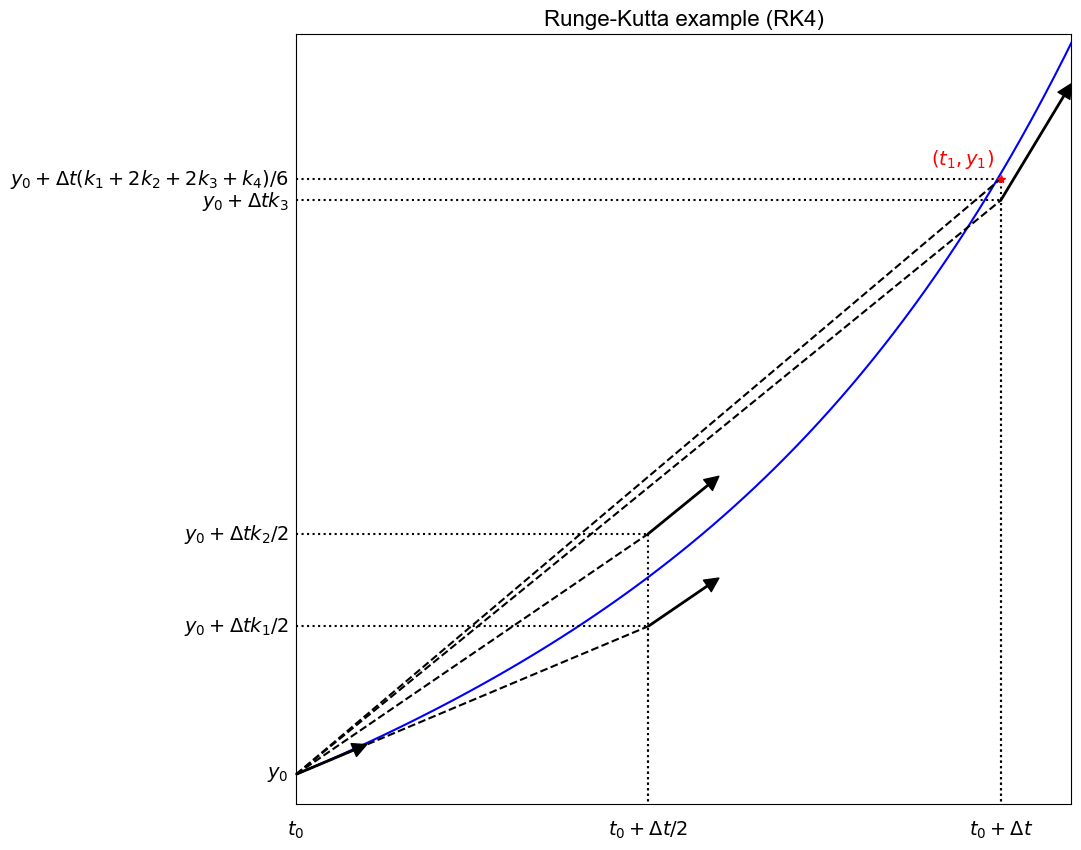

In [14]:
# example problem taken from Wikipedia entry on RK
def f(t, y):
    return y + t**3


def y(t):
    return 7*np.exp(t) - t**3 - 3*t**2 - 6*t - 6


fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111)
ax1.set_title('Runge-Kutta example (RK4)', fontsize=16)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlim([0,1.1])
ax1.set_ylim([0.9,3.5])
# define our x for plotting purposes
t = np.linspace(0, 1.5, 100)

# plot the exact solution
ax1.plot(t, y(t), 'b')

# initial time
t0 = 0.
# initial y
y0 = y(t0)
# example time step
dt = 1.
# the stages k multiplied by dt
k1 = dt*f(t0, y0)
k2 = dt*f(t0 + 0.5*dt, y0 + 0.5*k1)
k3 = dt*f(t0 + 0.5*dt, y0 + 0.5*k2)
k4 = dt*f(t0 + dt, y0 + k3)
y_new = y0 + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)
print('Exact solution, RK4 approximation: ', y(t0+dt), y_new)

# length of the arrows indicating slopes
grad_length = 0.1
ax1.annotate("", xy=(t0+grad_length, y0+grad_length*(k1/dt)), xytext=(t0, y0), arrowprops=dict(width=1, headlength=10, headwidth=10, facecolor='black'))
ax1.plot([t0, t0+0.5*dt], [y0, y0+0.5*k1], 'k--')
ax1.annotate("", xy=(t0 + 0.5*dt + grad_length, y0 + 0.5*k1+grad_length*(k2/dt)), xytext=(t0 + 0.5*dt, y0 + 0.5*k1), arrowprops=dict(width=1, headlength=10, headwidth=10, facecolor='black'))
ax1.plot([t0, t0+0.5*dt], [y0, y0+0.5*k2], 'k--')
ax1.annotate("", xy=(t0 + 0.5*dt + grad_length, y0 + 0.5*k2+grad_length*(k3/dt)), xytext=(t0 + 0.5*dt, y0 + 0.5*k2), arrowprops=dict(width=1, headlength=10, headwidth=10, facecolor='black'))
ax1.plot([t0, t0+dt], [y0, y0+k3], 'k--')
ax1.annotate("", xy=(t0 + dt + grad_length, y0 + k3+grad_length*(k4/dt)), xytext=(t0 + dt, y0 + k3), arrowprops=dict(width=1, headlength=10, headwidth=10, facecolor='black'))
ax1.plot([t0, t0+dt], [y0, y0+(1./6.)*(k1 + 2*k2 + 2*k3 + k4)], 'k--')

ax1.text(t0-0.01, y0, '$y_0$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.text(t0, 0.85, '$t_0$', horizontalalignment='center', verticalalignment='top', fontsize=14)
ax1.text(t0-0.01, y0+0.5*k1, '$y_0+\Delta t k_1/2$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.text(t0+0.5*dt, 0.85, '$t_0+\Delta t/2$', horizontalalignment='center', verticalalignment='top', fontsize=14)
ax1.plot([t0, t0+0.5*dt], [y0+0.5*k1, y0+0.5*k1], 'k:')
ax1.plot([t0+0.5*dt, t0+0.5*dt], [-0.1, y0+0.5*k1], 'k:')
ax1.text(t0-0.01, y0+0.5*k2, '$y_0+\Delta t k_2/2$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.plot([t0, t0+0.5*dt], [y0+0.5*k2, y0+0.5*k2], 'k:')
ax1.plot([t0+0.5*dt, t0+0.5*dt], [-0.1, y0+0.5*k2], 'k:')
ax1.text(t0-0.01, y0+k3, '$y_0+\Delta t k_3$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.text(t0+dt, 0.85, '$t_0+\Delta t$', horizontalalignment='center', verticalalignment='top', fontsize=14)
ax1.plot([t0, t0+dt], [y0+k3, y0+k3], 'k:')
ax1.plot([t0+dt, t0+dt], [-0.1, y0+k3], 'k:')
ax1.text(t0-0.01, y0+(1./6.)*(k1 + 2*k2 + 2*k3 + k4), '$y_0+\Delta t (k_1 + 2k_2 + 2k_3 + k_4)/6$', horizontalalignment='right', verticalalignment='center', fontsize=14)
ax1.plot([t0, t0+dt], [y0+(1./6.)*(k1 + 2*k2 + 2*k3 + k4), y0+(1./6.)*(k1 + 2*k2 + 2*k3 + k4)], 'k:')
ax1.plot([t0+dt, t0+dt], [-0.1, y0+(1./6.)*(k1 + 2*k2 + 2*k3 + k4)], 'k:')
ax1.plot([t0+dt], [y0+(1./6.)*(k1 + 2*k2 + 2*k3 + k4)], 'r*')
ax1.text(t0+dt-0.01, y0+(1./6.)*(k1 + 2*k2 + 2*k3 + k4)+0.03, '$(t_1,y_1)$', color='r', horizontalalignment='right', verticalalignment='bottom', fontsize=14);

#### Comments

As we hoped, we've clearly done more work here but have got a more accurate result.




## Runge-Kutta stability analysis  [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
In order to understand the stability of RK schemes, let's consider again our linear model problem

### RK2 stability

$$y'=\lambda y, \;\;\;\;\; y(0)=y_0.$$

Let's consider our RK2($\alpha$) scheme applied to this problem. 

Recall that this method takes the general form 

$$
\begin{align*}
k_1 & =  f(t_n, y_n), \\[10pt]
k_2 & =  f(t_n + \alpha\, \Delta t, y_n + \alpha \, \Delta t\, k_1), \\[10pt]
y_{n+1} &= y_n + \left( 1 - \frac{1}{2\alpha}\right) \, \Delta t\, k_1 + 
 \frac{1}{2\alpha} \, \Delta t\, k_2, 
\end{align*}
$$

and so in the case of this particular model problem we have

$$
\begin{align*}
k_1 & =  \lambda y_n, \\[10pt]
k_2 & =  \lambda \left( y_n + \alpha \, \Delta t\, k_1 \right)
 =  \lambda \left( 1 + \alpha \, \Delta t \, \lambda \right) y_n, \\[10pt]
y_{n+1} &= y_n + \left( 1 - \frac{1}{2\alpha}\right)\, \Delta t\, k_1 + 
 \frac{1}{2\alpha}\, \Delta t\, k_2 \\[10pt]
 & = y_n + \left( 1 - \frac{1}{2\alpha}\right) \Delta t \lambda y_n + 
 \frac{1}{2\alpha} \Delta t \lambda \left( 1 + \alpha \Delta t \lambda \right) y_n\\[10pt]
 & = y_n  \left( 1 + \lambda \Delta t + \frac{\lambda^2\Delta t^2}{2}\right).
\end{align*}
$$

So the *amplification factor* for the RK2 family of methods is given by

$$\sigma = \left( 1 + \lambda \Delta t + \frac{\lambda^2\Delta t^2}{2}\right).$$

Note from this that the stability of the scheme is not dependent on the choice of the parameter $\alpha$.

```


**Aside:**

Note that the expansion that appeared in the derivation above is equivalent to

$$
\begin{align*}
y_{n+1} & =  y_n + \Delta t \lambda  y_n + \frac{\Delta t^2}{2!}\lambda^2 y_n \\[10pt]
& = y_n + \Delta t f_n + \frac{\Delta t^2} {2!}   (f_{t_n} + f_n \, f_{y_n}),
\end{align*}
$$

since for this test case $\;\;f_n = \lambda y_n\;\;$ and $\;\;f_{t_n} + f_n \, f_{y_n} = 0 + \lambda y_n \lambda = \lambda^2 y_n$.

Which, recalling the Taylor series methods above, confirms the method is second-order accurate for this problem, 

(as we already know more generally by construction of course!)


Given the amplification factor we can plot the stability region in the same way as we did for the simpler schemes at the start of this lecture:



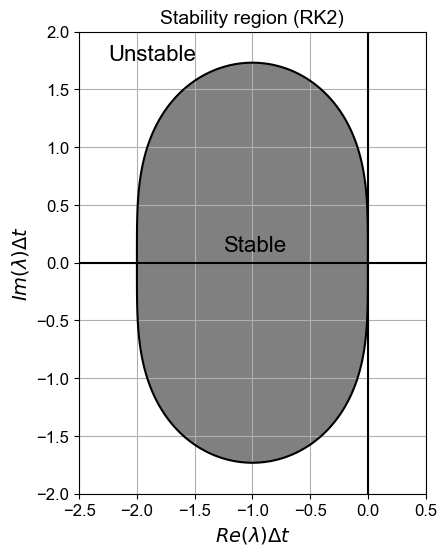

In [15]:
# RK2 stability region

# set up a mesh in x,y
x = np.linspace(-2.5, 0.5, 100)
y = np.linspace(-2., 2., 100)
xx, yy = np.meshgrid(x, y)

# define a complex parameter which is our lambda * dt quantity
lamdt = xx + 1j*yy

# compute the "amplification factor" for RK2
amp = 1 + lamdt + lamdt*lamdt/2.

# and its magnitude - we want this to be less than one for stability
ampmag = np.abs(amp)

# set up our figs for plotting
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

# plot the RK2 stability region
ax1.contour(x, y, ampmag, [1.0], colors=('k'))
ax1.contourf(x, y, ampmag, (0.0, 1.0), colors=('grey'))
ax1.set_aspect('equal')
ax1.grid(True)
ax1.set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=14)
ax1.set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=14)
ax1.set_title('Stability region (RK2)', fontsize=14)
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
ax1.text(-1.25, 0.1, 'Stable', fontsize=16)
ax1.text(-2.25, 1.75, 'Unstable', fontsize=16);


#### Comments

- For purely real $\lambda$ this represents the same stability bound as forward Euler, but there is an improvement for complex $\lambda$.


- The method is still unconditionally unstable for purely imaginary $\lambda$, i.e. for a purely imaginary eigenvalue no choice of time step size leads to stability.




### RK4 stability

If we go through the same process for RK4 we arrive at the amplification factor

$$\sigma =  \left( 1 + \lambda \Delta t + \frac{\lambda^2\Delta t^2}{2} + \frac{\lambda^3\Delta t^3}{6} + \frac{\lambda^4\Delta t^4}{24} \right).$$

Let's plot this to see what it tells us.



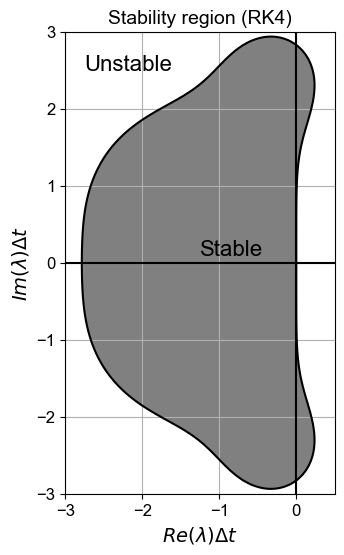

In [16]:
# RK4 stability region

# set up a mesh in x,y
x = np.linspace(-3., 0.5, 100)
y = np.linspace(-3., 3., 100)
xx, yy = np.meshgrid(x, y)

# define a complex parameter which is our lambda * dt quantity
lamdt = xx + 1j*yy

# compute the "amplification factor" for RK4
amp = 1 + lamdt + lamdt**2/2 + lamdt**3/6 + lamdt**4/24

# and its magnitude - we want this to be less than one for stability
ampmag = np.abs(amp)

# set up our figs for plotting
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

# plot the RK4 stability region
ax1.contour(x, y, ampmag, [1.0], colors=('k'))
ax1.contourf(x, y, ampmag, (0.0, 1.0), colors=('grey'))
ax1.set_aspect('equal')
ax1.grid(True)
ax1.set_xlabel(r'$Re(\lambda)\Delta t$', fontsize=14)
ax1.set_ylabel(r'$Im(\lambda)\Delta t$', fontsize=14)
ax1.set_title('Stability region (RK4)', fontsize=14)
ax1.axhline(y=0, color='k')
ax1.axvline(x=0, color='k')
ax1.text(-1.25, 0.1, 'Stable', fontsize=16)
ax1.text(-2.75, 2.5, 'Unstable', fontsize=16);

    
#### Comments

- So this represents a significant improvement for both purely real, as well as complex valued $\lambda$.


- Note that it is also stable for a large range of purely imaginary values.


- It is actually also stable in a couple of patches for $\lambda$ values with positive real parts, i.e. in situations where the exact solution actually grows in time RK4 is artificially stable (the numerical solution decays). Physically this is clearly wrong, but there may be situations where this extra "robustness" could be useful.


- Note that Runge-Kutta schemes achieve high order through additional function evaluations; RK4 uses only four function evaluations to achieve fourth-order accuracy (note that for higher-order explicit methods even larger numbers of function evaluations are needed: 5th order RK needs six function evaluations for example. So RK4 represents a bit of a sweet spot. A table of minimum number of stages to achieve a given order, from 1 up to 8, is given [here](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#Explicit_Runge%E2%80%93Kutta_methods)). 


- This efficiency, along with its good stability and accuracy properties, and ease of implementation, is the ***reason that RK4 is an extremely popular method***.


For more on the topic of choosing RK methods, and in particular which order, take a look at the interesting discussion here: <https://scicomp.stackexchange.com/questions/25581/why-are-higher-order-runge-kutta-methods-not-used-more-often>




## Adaptive time-stepping  [$\star$]
```{admonition} Optional Content
:class: dropdown
An advantage of multi-stage, single step methods is that it is (relatively!) easy to change the time step size.  But we need to know something about the error in the solution to decide on an appropriate local time step size.

Similarly to some of the ideas from Lecture 2 on quadrature methods, there are two ways to estimate the error. 

The first is to apply the integration scheme with two different time step sizes and use the difference as the basis for an error estimate.

The second is to use two schemes with different orders of accuracy. If this is done carefully then the majority of the function evaluations can be reused (cf. our comment on "embedded Runge-Kutta pairs" above), i.e. without the cost of evaluating two arbitrary schemes.

There are several popular schemes to achieve this, e.g.
<https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method>
<https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method>

For more information on error estimators, including the one we will implement in the homework, see  Chapter II.4 (Practical Error Estimation and Step Size Selection) of *Solving Ordinary Differential Equations I: Nonstiff Problems* by Hairer, Nørsett and Wanner.
```



## Stiff problems [$\star$]
```{admonition} Optional Content
:class: dropdown
An ODE can be characterised as being [*stiff*](https://uk.mathworks.com/company/newsletters/articles/stiff-differential-equations.html) if some of the following describe it:

- the step size required for stability is much smaller than the step size required for accuracy


- it contains some transients that decay rapidly compared to the major transient of interest (what we mean here is that there is dynamics in the system that we do not necessarily care about (for the question we're solving) and can potentially safely ignore, or not care if we excessively damp) - we saw an example of this under the L-stability section


- one eigenvalue of the system is negative and large compared to the other eigenvalues of the system


<br>

Whether a problem is stiff or non-stiff has important implications for the stability and the selection of appropriate time step size as well as appropriate numerical methods to use: <https://en.wikipedia.org/wiki/Stiff_equation> - stiff problems are in general more difficult to deal with numerically.
```




    
## An example of a stiff problem  [$\star$]
```{admonition} Optional Content
:class: dropdown
For example, the problem

$$ y'' - 1001 y' + 1000y = 0 , $$

or equivalently

$$ \boldsymbol{z}'=A\boldsymbol{z}\;\;\;\text{where}
\;\;\;\; \boldsymbol{z} = 
\begin{bmatrix}
y\\
y'
\end{bmatrix}
\;\;\;\text{and}
\;\;\;\; 
A =
\begin{bmatrix}
0 & 1\\
-1000 & -1001
\end{bmatrix},$$

is stiff (and of course is a variant of our MSD problem
from the previous lecture).

The eigenvalues here are $\lambda_1 = -1000$ and $\lambda_2 = -1$. Hence, this problem satsifies our definition of stiffness as per the eigenvalue based characterisation given above.

Also, the general solution to this problem is given by

$$ y(t) = C_1 \text{e}^{-1000t} + C_2 \text{e}^{-t}, $$

so after the $\text{e}^{-1000t}$ component has died away
(or due to the initial conditions is never excited in the first place) we would hope to be able to use a larger time step, but the presence of the large eigenvalue prevents us from doing this.

A generalisation of this problem is considered in the homework. The van der Pol oscillator is another example of a stiff  (depending on choice of a physical parameter) problem considered in the homework.
```



## Backward differentiation formula (BDF) methods  [$\star$]
```{admonition} Optional Content
:class: dropdown
Note that while the *Adams* family of LMS methods introduced above are popular for non-stiff problems, 

for stiff problems so-called BDF methods are preferred.

[*Backward differentiation formula (BDF) methods*](https://en.wikipedia.org/wiki/Backward_differentiation_formula) represent a family of (linear multistep) methods well-suited to solve stiff ODEs.


The entire family of BDF methods are:

$$
\begin{alignat}{4}
\textrm{BDF1:} &\;\;\;\; &  y_{n+1}-y_{n}  &= &{\Delta t}\; f_{n+1} \\
\textrm{BDF2:} &\;\;\;\; & 3y_{n+2} - 4y_{n+1} + y_{n} &= 2 &{\Delta t}\; f_{n+2} \\
\textrm{BDF3:} &\;\;\;\; & 11y_{n+3} - 18y_{n+2} + 9y_{n+1} - 2y_{n} &= 6 &{\Delta t}\; f_{n+3} \\
\textrm{BDF4:} &\;\;\;\; & 25y_{n+4} - 48y_{n+3} + 36y_{n+2} - 16y_{n+1} + 3y_{n} &= 12 &{\Delta t}\; f_{n+4} \\
\textrm{BDF5:} &\;\;\;\; & 137y_{n+5} -300y_{n+4} + 300y_{n+3} - 200y_{n+2} + 75y_{n+1} - 12y_{n} &= 60 &{\Delta t}\; f_{n+5} \\
\textrm{BDF6:} &\;\;\;\; & 147y_{n+6} -360y_{n+5} +450y_{n+4} - 400y_{n+3} + 225y_{n+2} - 72y_{n+1} + 10y_{n} &= 60 &{\Delta t}\; f_{n+6} 
\end{alignat}
$$

and it should be no surprise that BDF1 is simply backward Euler.

The order of each method is one lower than the number of levels employed, i.e. BDF1 is first-order and BDF6 is sixth-order.

Note that these are clearly not of "Adams" type since they move all of the free parameter choice over to the $\alpha$'s rather than the $\beta$'s, with $f$ on the RHS evaluated at the new time level only.

```


## Derivation of BDF methods  [$\star\star$]
```{admonition} Advanced Content
:class: dropdown
The BDF schemes can be derived by fitting a Lagrange interpolating polynomial to $y$ (i.e. the $y$ data at a certain number of previous time levels, as well as the new level) and differentiating this to approximate the derivative of $y$ w.r.t. $t$ appearing on the LHS of the ODE, and then setting this equal to the RHS function evaluated at the new time leve.

Consider the case $s=2$, i.e. we have data from levels $n$, $n+1$ and are seeking the solution at time level $n+2$.

Recall that the Lagrange interpolating polynomial is given by 

$$L(t) := \sum_{i=0}^{N} y_i \ell_i(t),$$

where

$$\ell_i(t) := \prod_{\begin{smallmatrix}0\le m\le N\\ m\neq i\end{smallmatrix}} \frac{t-t_m}{t_i-t_m} = \frac{(t-t_0)}{(t_i-t_0)} \cdots \frac{(t-t_{i-1})}{(t_i-t_{i-1})} \frac{(t-t_{i+1})}{(t_i-t_{i+1})} \cdots \frac{(t-t_N)}{(t_i-t_N)},$$

where $0\le i\le N$.

In our case where $N=2$ and our indices run over $n$, $n+1$ and $n+2$ we have

$$y(t) \approx L(t) :=  y_{n} \ell_n(t) + y_{n+1} \ell_{n+1}(t) y_{n+1} +  \ell_{n+2}(t)y_{n+2},$$

where

$$ \ell_n(t) = \frac{(t-t_{n+1})(t-t_{n+2})}{ (t_n-t_{n+1})(t_n-t_{n+2})}, \;\;\;
\ell_{n+1}(t) = \frac{(t-t_{n})(t-t_{n+2})}{ (t_{n+1}-t_{n})(t_{n+1}-t_{n+2})}, \;\;\;
\ell_{n+2}(t) = \frac{(t-t_{n})(t-t_{n+1})}{ (t_{n+2}-t_{n})(t_{n+2}-t_{n+1})}. $$

We actually want $dy/dt$ which we can approximate via

$$ \frac{dy}{dt} \approx\frac{dL}{dt} = y_{n} \frac{d\ell_n(t)}{dt} + y_{n+1} \frac{\ell_{n+1}(t)}{dt} +  y_{n+2} \frac{\ell_{n+2}(t)}{dt}.$$

Assuming for simplicity that the time step is uniform and of size $\Delta t$, then the derivatives of the individual Lagrange basis polynomials are 

$$ 
\frac{d\ell_n(t)}{dt} = \frac{2t - t_{n+1} -t_{n+2}}{ 2\Delta t^2 }, \;\;\;
\ell_{n+1}(t) = \frac{2t -t_{n} -t_{n+2}}{ -\Delta t^2 }, \;\;\;
\ell_{n+2}(t) = \frac{2t -t_{n} -t_{n+1}}{ 2\Delta t^2 }. $$

Finally, given that we evaluate the RHS of the ODE at the new time level, i.e. $f_{n+2}$ in this case, we want to evaluate our approximation to the derivative of $y$ also at this new time level:

$$
\begin{align*}
f_{n+2} = \left. \frac{dy(t)}{dt} \right|_{t=t_{n+2}} \approx \left.\frac{dL}{dt}\right|_{t=t_{n+2}}  
& =  
y_{n} \frac{2t_{n+2} - t_{n+1} -t_{n+2}}{ 2\Delta t^2 } + y_{n+1} \frac{2t_{n+2} -t_{n} -t_{n+2}}{ -\Delta t^2 } +   y_{n+2} \frac{2t_{n+2} -t_{n} -t_{n+1}}{ 2\Delta t^2 }\\[10pt]
& =  
y_{n} \frac{\Delta t}{ 2\Delta t^2 } + y_{n+1} \frac{2\Delta t}{ -\Delta t^2 } +   y_{n2} \frac{3\Delta t}{ 2\Delta t^2 }
\\[10pt]
& =  
y_{n} \frac{1}{ 2\Delta t } - y_{n+1} \frac{2}{ \Delta t } +   y_{n+2} \frac{3}{ 2\Delta t }.
\end{align*}
$$

Therefore (multiplying through by $2\,\Delta t$) we have

$$ 3y_{n+2} - 4y_{n+1} + y_{n} = 2 {\Delta t}\; f_{n+2}. $$
```



## BDF stability regions  [$\star$]
```{admonition} Optional Content
:class: dropdown
Again, we skip the details and just plot the absolute stability regions:
```


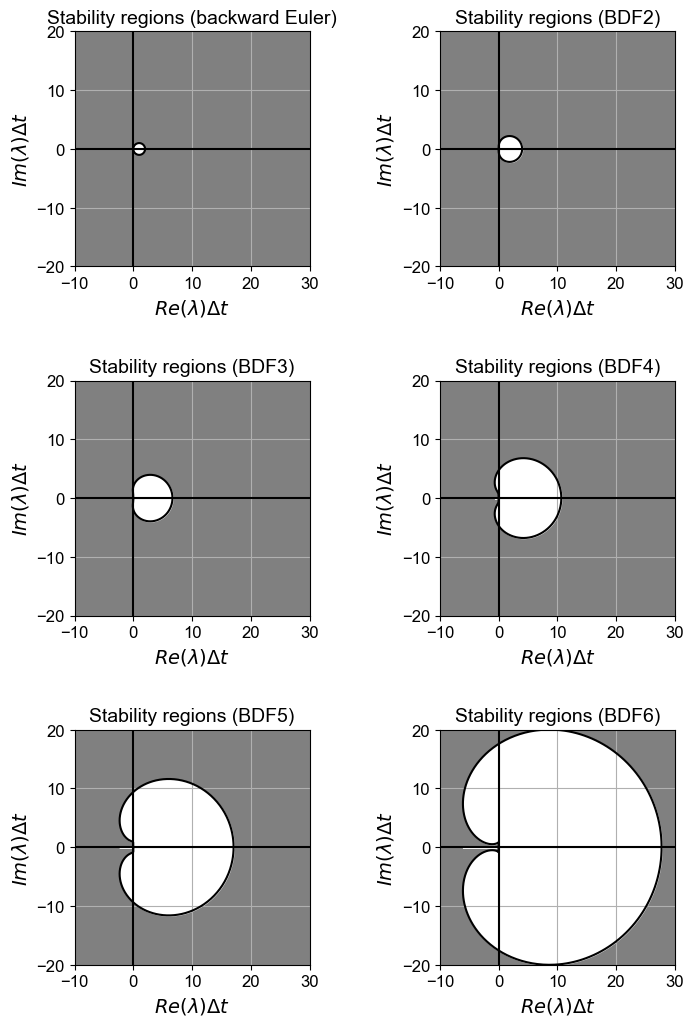

In [17]:
# let's calculate and plot the stability region for our discrete schemes
x = np.linspace(-10, 30, 400)
y = np.linspace(-20, 20, 400)
xx, yy = np.meshgrid(x, y)
lamdt = xx + 1j*yy

# backward Euler amplification factor,  and its magnitude
BEamp = 1.0/(1 - lamdt)
BEampmag = np.abs(BEamp)

# set up our figs for plotting
fig, axs = plt.subplots(3, 2, figsize=(7, 10))
fig.tight_layout(w_pad=4, h_pad=5)
# reshape the list of axes as we are going to use in a loop
axs = axs.reshape(-1)

# plot the backward Euler stability region
axs[0].contour(x, y, BEampmag, [1.0], colors=('k'))
axs[0].contourf(x, y, BEampmag, (0.0, 1.0), colors=('grey'))

def add_fig_niceties(ax, title):
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel('$Re(\lambda)\Delta t$', fontsize=14)
    ax.set_ylabel('$Im(\lambda)\Delta t$', fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_xlim([-10, 30])
    ax.set_ylim([-20, 20])

add_fig_niceties(axs[0],'Stability regions (backward Euler)')
    
# plot the BDF2 stability region

theta = np.linspace(0., 2.*np.pi, 1000)
e_i_theta = np.exp(1j*theta)

z = (3.*e_i_theta**2 - 4.*e_i_theta + 1.) / (2.*e_i_theta**2)

axs[1].plot(z.real, z.imag, 'k')
axs[1].fill_between([-100, 100], [-100,-100], [100,100], color=('grey'))
axs[1].fill_between(z.real, z.imag, color=('white'))
add_fig_niceties(axs[1],'Stability regions (BDF2)')


# plot the BDF3 stability region
z = (11.*e_i_theta**3 - 18.*e_i_theta**2 + 9.*e_i_theta - 2.) / (6.*e_i_theta**3)

axs[2].plot(z.real, z.imag, 'k')
axs[2].fill_between([-100, 100], [-100,-100], [100,100], color=('grey'))
axs[2].fill_between(z.real, z.imag, color=('white'))
add_fig_niceties(axs[2],'Stability regions (BDF3)')

# plot the BDF4 stability region
z = (25.*e_i_theta**4 - 48.*e_i_theta**3 + 36.*e_i_theta**2 - 16.*e_i_theta + 3) / (12.*e_i_theta**4)

axs[3].plot(z.real, z.imag, 'k')
axs[3].fill_between([-100, 100], [-100,-100], [100,100], color=('grey'))
axs[3].fill_between(z.real, z.imag, color=('white'))
add_fig_niceties(axs[3],'Stability regions (BDF4)')


# plot the BDF5 stability region
z = 0
for i in range(1,6):
    z = z + (1. - 1./e_i_theta)**i / i 

axs[4].plot(z.real, z.imag, 'k')
axs[4].fill_between([-100, 100], [-100,-100], [100,100], color=('grey'))
axs[4].fill_between(z.real, z.imag, color=('white'))
add_fig_niceties(axs[4],'Stability regions (BDF5)')

# plot the BDF6 stability region
z = 0
for i in range(1,7):
    z = z + (1. - 1./e_i_theta)**i / i 

axs[5].plot(z.real, z.imag, 'k')
axs[5].fill_between([-100, 100], [-100,-100], [100,100], color=('grey'))
axs[5].fill_between(z.real, z.imag, color=('white'))
add_fig_niceties(axs[5],'Stability regions (BDF6)')


#### Comments

- Recall our definition of A($\alpha$) stability from above - the BDF methods are A($\alpha$) with $\alpha$ values of 90, 90, 88, 73, 51 and 18 *degrees* for BDF 1 - 6 respectively [LeVeque - FD - section 8.4].


- BDF methods of order greater than 6, i.e. which use more than 7 levels, are not zero stable and so are unusable.



## Final remarks


- Stability increases robustness but generally comes at computational expense, particularly if the ODE is nonlinear.


- Stability does not imply accuracy!


- For a given truncation error, there is a trade-off between how much past information you store in memory (multi-step methods) and how many calculations you make (intermediate-step methods).


- Which time-integration scheme you choose depends on the problem under consideration.



## Summary

In this lecture we extended our knowledge of ODE solvers through the introduction and derivation of both the linear multi-step (LMS) and Runge-Kutta (RK) families of methods, including implicit versions of these.

We went into more detail on stability, error analysis and time step size selection.

We discussed some of the practical considerations.

Next we will start considering the discretisation of space, leading on to the solutions of PDEs.